In [1]:
import os
import glob
import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns
from itertools import compress

sys.path.append('../')
import src.utils as my_u
from src.utils import df_cp
from src.utils import df_log
from src.utils import df_total20000
from src.utils import df_minmax
from src.utils import df_minmax_scaler
from src.utils import df_l2norm
from src.utils import df_zscore
from src.utils import df_meansquare
from src.utils import run_plot
import random

In [2]:
import scanpy

In [3]:
mouse_label = pd.read_csv('../data/tabular_muris/01_droplet_raw_data/metadata_droplet.csv', sep=',', header=0)
mouse_dic = dict(mouse_label[['channel','mouse.id']].values)
mouse_dic

{'10X_P4_0': '3-M-8',
 '10X_P4_1': '3-M-9',
 '10X_P4_2': '3-M-8/9',
 '10X_P4_3': '3-M-8',
 '10X_P4_4': '3-M-9',
 '10X_P4_5': '3-M-8',
 '10X_P4_6': '3-M-9',
 '10X_P4_7': '3-M-8',
 '10X_P7_0': '3-F-56',
 '10X_P7_1': '3-F-57',
 '10X_P7_2': '3-F-56',
 '10X_P7_3': '3-F-57',
 '10X_P7_4': '3-F-56',
 '10X_P7_5': '3-F-57',
 '10X_P7_6': '3-F-56',
 '10X_P7_7': '3-F-56',
 '10X_P7_8': '3-F-56',
 '10X_P7_9': '3-F-57',
 '10X_P7_10': '3-F-56',
 '10X_P7_11': '3-F-56',
 '10X_P7_12': '3-F-56',
 '10X_P7_13': '3-F-57',
 '10X_P7_14': '3-F-56',
 '10X_P7_15': '3-F-57',
 '10X_P8_12': '3-M-5/6',
 '10X_P8_13': '3-M-7/8',
 '10X_P8_14': '3-M-5/6',
 '10X_P8_15': '3-M-7/8'}

# one organ {'Liver', 'Thym', 'Splee', 'Marrow', 'Kidney', 'Bladder', 'Lung'}


# Bladder

In [4]:
ORGAN = 'Bladder'

tabula_file_list = glob.glob("../data/tabular_muris/00_facs_raw_data/FACS/*"+ORGAN+"*.csv")
print(tabula_file_list)

tabula_10xfile_list = glob.glob("../data/tabular_muris/01_droplet_raw_data/droplet/*"+ORGAN+"*")
print(tabula_10xfile_list)

# Tabula data load
#
tabula_labels = []
tabula_data = pd.DataFrame()
for ff in tabula_file_list:
    data = pd.read_csv(ff, sep=',', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    tabula_data = pd.concat([tabula_data, data.iloc[c,]], axis=0)
    tabula_labels += [ff.rstrip('-counts.csv').split('/')[-1]] * data.shape[0]
    print(tabula_data.shape)

tabula_labels_set = set(tabula_labels)

# Tabula label load
#
annot_label = pd.read_csv('../data/tabular_muris/00_facs_raw_data/annotations_FACS.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_data.index)
m = annot_label.filter(com, axis=0)
tabula_data = tabula_data.filter(com, axis=0)
tabula_data = pd.concat([tabula_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue = tabula_data['tissue']
tabula_labels = tabula_data['cell_ontology_class']
tissue = tissue.values.tolist()
tabula_labels = tabula_labels.values.tolist()

tabula_data.pop('cell_ontology_class')
tabula_data.pop('tissue')
tabula_data.pop('zsGreen_transgene')
print(set(tabula_labels))

# Tabula 10x data load
#
tabula_10x_batches = []
tabula_10x_data = pd.DataFrame()
for ff in tabula_10xfile_list:
    data = scanpy.read_10x_mtx(ff)
    data = data.to_df()
    prefix_cell = ff.split('-')[1]
    data.index = [prefix_cell +'_'+x.split('-')[0] for x in data.index]
    tabula_10x_data = pd.concat([tabula_10x_data, data], axis=0)
    tabula_10x_batches += [ff.split('/')[-1].split('-')[1]] * data.shape[0]
    print(tabula_10x_data.shape)

# Tabula 10x label load
#
annot_label = pd.read_csv('../data/tabular_muris/01_droplet_raw_data/annotations_droplet.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_10x_data.index)
m = annot_label.filter(com, axis=0)
tabula_10x_data = tabula_10x_data.filter(com, axis=0)
tabula_10x_data = pd.concat([tabula_10x_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue_10x = tabula_10x_data['tissue']
tabula_10x_labels = tabula_10x_data['cell_ontology_class']
tissue_10x = tissue_10x.values.tolist()
tabula_10x_labels = tabula_10x_labels.values.tolist()

tabula_10x_data.pop('cell_ontology_class')
tabula_10x_data.pop('tissue')
tabula_10x_data.pop('zsGreen_transgene')
print(set(tabula_10x_labels))


# MCA load
#
mca_file_list = glob.glob("../dataset/MCA/mousecellatlas/*"+ORGAN+"*.txt")
print((mca_file_list))

mca_labels = []
mca_data = pd.DataFrame()
for ff in mca_file_list:
    data = pd.read_csv(ff, sep='\s+', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    data = data.iloc[c,]
    # use gene set from tabula_data (intersection with tabula_data)
    common = tabula_data.columns.intersection(data.columns)
    data.sort_index(axis=1, inplace=True)
    data = data.filter(common, axis=1)
    mca_data = pd.concat([mca_data, data], axis=0)
    mca_labels += [ff.split('/')[-1].split('_')[1]] * data.shape[0]
mca_data.replace(np.nan,0)
mca_label_set = set(mca_labels)
print(mca_label_set)

annot_label = pd.read_csv("../dataset/MCA/mousecellatlas/MCA_CellAssignments.csv", sep=',', index_col=1, header=0)
#print(annot_label['Annotation'])
com = annot_label['Annotation'].index.intersection(mca_data.index)
m = annot_label.filter(com, axis=0)

mca_data = mca_data.filter(com, axis=0)
mca_data = pd.concat([mca_data, m[['Tissue','Annotation']]],axis =1)

mca_tissue = mca_data['Tissue']
mca_labels = mca_data['Annotation']
mca_tissue = mca_tissue.values.tolist()
mca_labels = mca_labels.values.tolist()

mca_data.pop('Tissue')
mca_data.pop('Annotation')
print(set(list(mca_labels)))
print(set(mca_tissue))

total_data = pd.concat([tabula_data, tabula_10x_data, mca_data], axis=0)
labels = tissue + tissue_10x + mca_tissue #mca_labels
labels_cell = tabula_labels + tabula_10x_labels + mca_labels #mca_labels
blabels = ['FACS_'+x.split('.')[2] for x in tabula_data.index] + ['10x_'+mouse_dic['_'.join(x.split('_')[0:3])] for x in tabula_10x_data.index] + ['MCA'] * len(mca_labels)
total_data = total_data.replace(np.NaN,0)
print('\nSummary')
print(total_data.shape)
print(set(labels))
print(set(labels_cell))
print(set(blabels))



['../data/tabular_muris/00_facs_raw_data/FACS/Bladder-counts.csv']
['../data/tabular_muris/01_droplet_raw_data/droplet/Bladder-10X_P4_4', '../data/tabular_muris/01_droplet_raw_data/droplet/Bladder-10X_P7_7', '../data/tabular_muris/01_droplet_raw_data/droplet/Bladder-10X_P4_3']
(1638, 23433)
{'mesenchymal cell', 'basal cell of urothelium', 'bladder cell'}
(1783, 23433)
(2351, 23433)
(2500, 23433)
{'leukocyte', 'basal cell of urothelium', 'mesenchymal cell', 'endothelial cell', 'bladder cell'}
['../dataset/MCA/mousecellatlas/GSM2889480_Bladder_dge.txt']
{'Bladder'}
{'Epithelial cell_Gm23935 high(Bladder)', 'Mesenchymal stromal cell(Bladder)', 'Macrophage_Pf4 high(Bladder)', 'Stromal cell_Car3 high(Bladder)', 'Umbrella cell(Bladder)', 'Vascular endothelial cell(Bladder)', 'Dendritic cell_Lyz2 high(Bladder)', 'Smooth muscle cell(Bladder)', 'Vascular smooth muscle progenitor cell(Bladder)', 'Epithelial cell_Upk3a high(Bladder)', 'Dendritic cell_Cd74 high(Bladder)', 'Endothelial cell_Ly6c1 h

In [5]:
new_labels = [x.split('_')[0].split('(')[0].lower().rstrip('s').split(' ')[0] for x in labels_cell]
print(set(new_labels))

{'leukocyte', 'nk', 'vascular', 'macrophage', 'mesenchymal', 'umbrella', 'basal', 'dendritic', 'urothelium', 'endothelial', 'bladder', 'epithelial', 'smooth', 'stromal'}


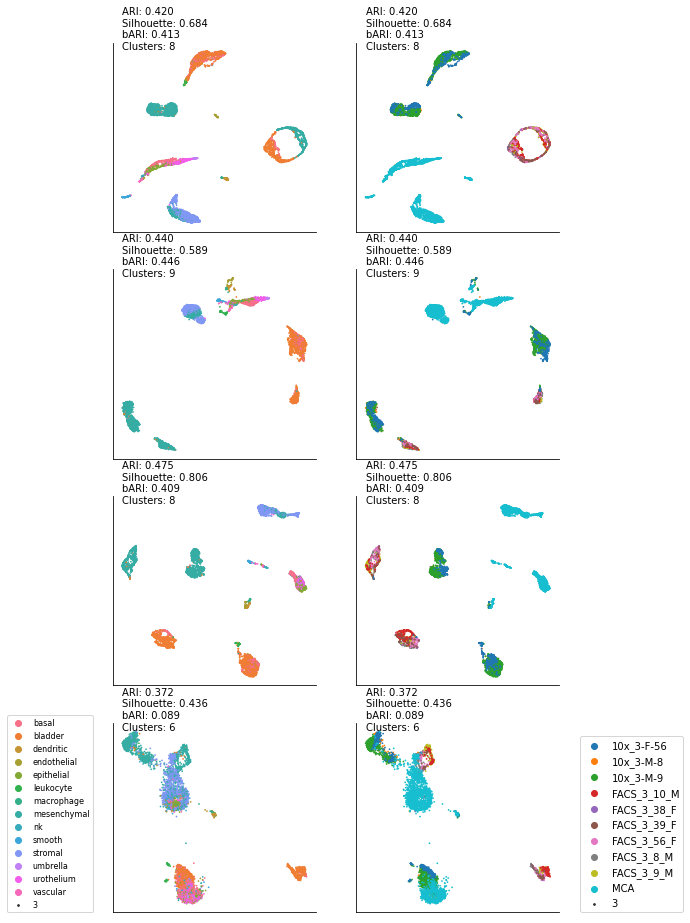

In [6]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1)) 

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot((total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_log(total_data), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_total20000(total_data), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_log(df_total20000(total_data)), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

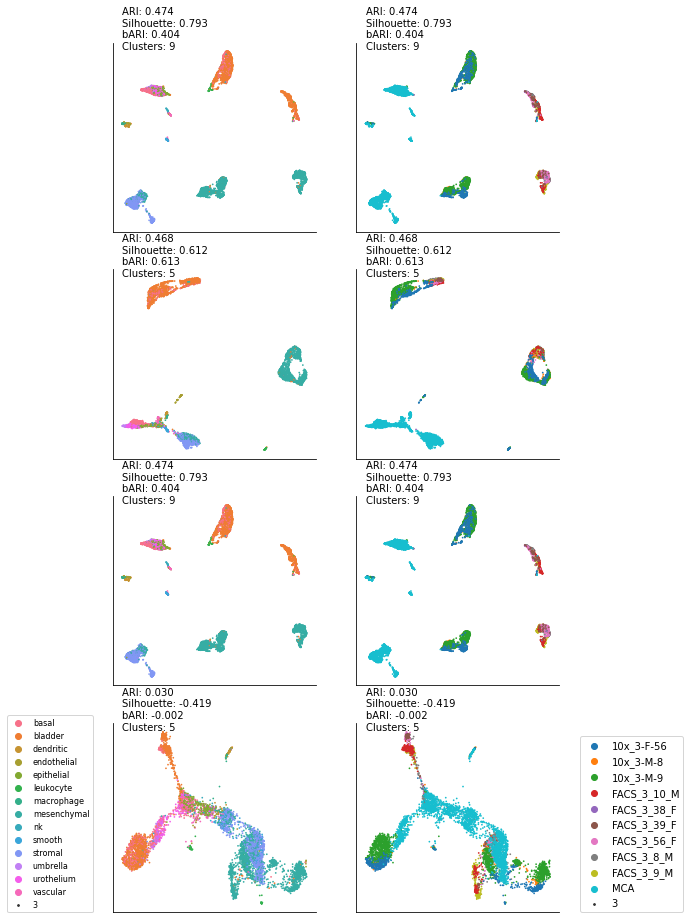

In [7]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

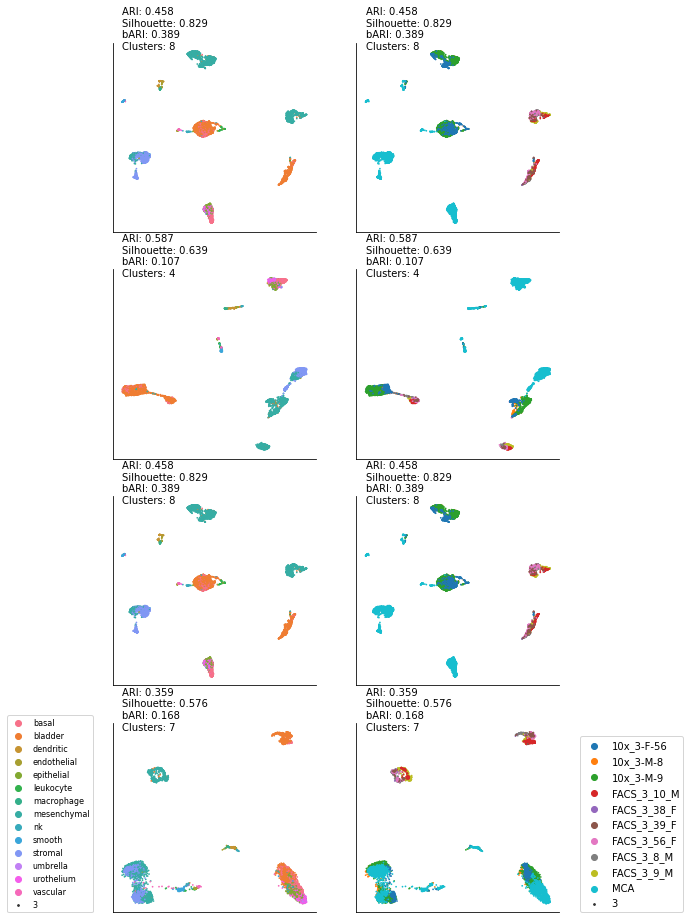

In [8]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

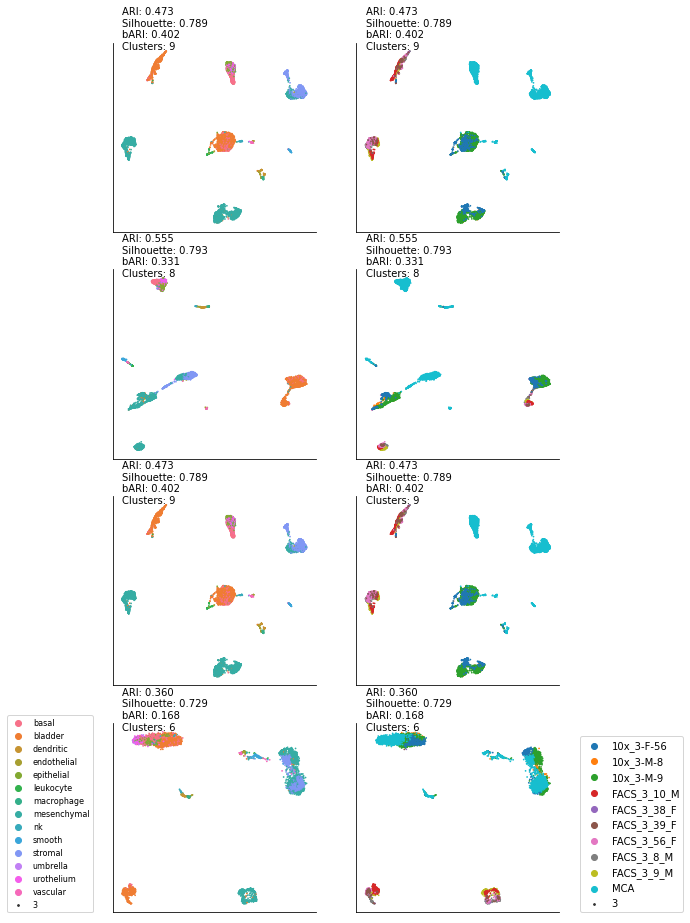

In [9]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

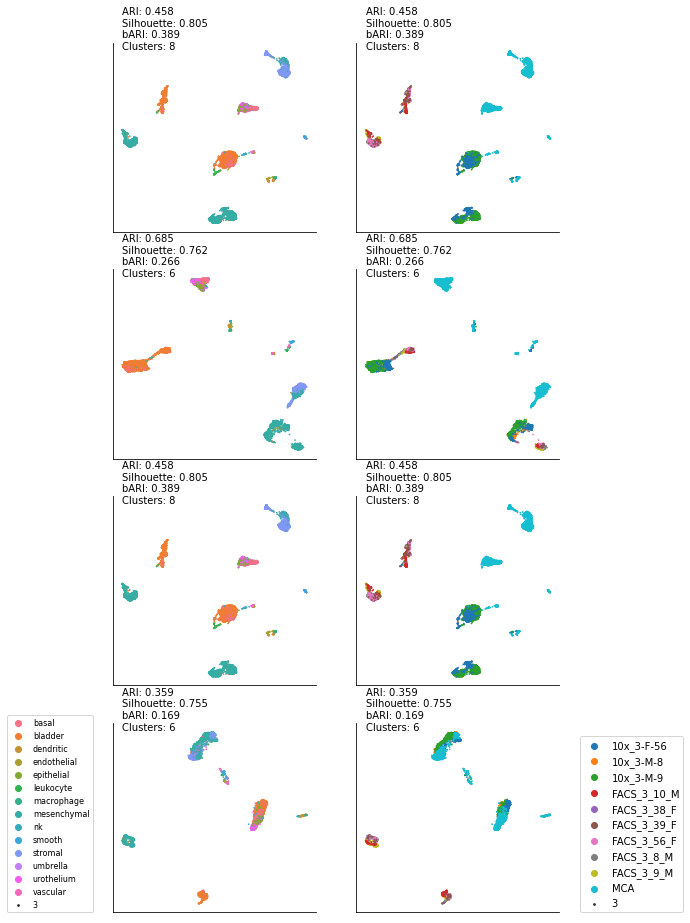

In [10]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

# LUNG

In [11]:
ORGAN = 'Lung'

tabula_file_list = glob.glob("../data/tabular_muris/00_facs_raw_data/FACS/*"+ORGAN+"*.csv")
print(tabula_file_list)

tabula_10xfile_list = glob.glob("../data/tabular_muris/01_droplet_raw_data/droplet/*"+ORGAN+"*")
print(tabula_10xfile_list)

# Tabula data load
#
tabula_labels = []
tabula_data = pd.DataFrame()
for ff in tabula_file_list:
    data = pd.read_csv(ff, sep=',', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    tabula_data = pd.concat([tabula_data, data.iloc[c,]], axis=0)
    tabula_labels += [ff.rstrip('-counts.csv').split('/')[-1]] * data.shape[0]
    print(tabula_data.shape)

tabula_labels_set = set(tabula_labels)

# Tabula label load
#
annot_label = pd.read_csv('../data/tabular_muris/00_facs_raw_data/annotations_FACS.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_data.index)
m = annot_label.filter(com, axis=0)
tabula_data = tabula_data.filter(com, axis=0)
tabula_data = pd.concat([tabula_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue = tabula_data['tissue']
tabula_labels = tabula_data['cell_ontology_class']
tissue = tissue.values.tolist()
tabula_labels = tabula_labels.values.tolist()

tabula_data.pop('cell_ontology_class')
tabula_data.pop('tissue')
tabula_data.pop('zsGreen_transgene')
print(set(tabula_labels))

# Tabula 10x data load
#
sample_per_class = 1000

tabula_10x_batches = []
tabula_10x_data = pd.DataFrame()
for ff in tabula_10xfile_list:
    data = scanpy.read_10x_mtx(ff)
    c = list(range(len(data.obs)))
    random.shuffle(c)
    c = c[:sample_per_class]
    data = data[c,]
    data = data.to_df()
    prefix_cell = ff.split('-')[1]
    data.index = [prefix_cell +'_'+x.split('-')[0] for x in data.index]
    tabula_10x_data = pd.concat([tabula_10x_data, data], axis=0)
    tabula_10x_batches += [ff.split('/')[-1].split('-')[1]] * data.shape[0]
    print(tabula_10x_data.shape)

# Tabula 10x label load
#
annot_label = pd.read_csv('../data/tabular_muris/01_droplet_raw_data/annotations_droplet.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_10x_data.index)
m = annot_label.filter(com, axis=0)
tabula_10x_data = tabula_10x_data.filter(com, axis=0)
tabula_10x_data = pd.concat([tabula_10x_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue_10x = tabula_10x_data['tissue']
tabula_10x_labels = tabula_10x_data['cell_ontology_class']
tissue_10x = tissue_10x.values.tolist()
tabula_10x_labels = tabula_10x_labels.values.tolist()

tabula_10x_data.pop('cell_ontology_class')
tabula_10x_data.pop('tissue')
tabula_10x_data.pop('zsGreen_transgene')
print(set(tabula_10x_labels))

# MCA load
#
mca_file_list = glob.glob("../dataset/MCA/mousecellatlas/*"+ORGAN+"*.txt")
print((mca_file_list))

mca_labels = []
mca_data = pd.DataFrame()
for ff in mca_file_list:
    data = pd.read_csv(ff, sep='\s+', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    random.shuffle(c)
    c = c[:sample_per_class]
    data = data.iloc[c,]
    # use gene set from tabula_data (intersection with tabula_data)
    common = tabula_data.columns.intersection(data.columns)
    data.sort_index(axis=1, inplace=True)
    data = data.filter(common, axis=1)
    mca_data = pd.concat([mca_data, data], axis=0)
    mca_labels += ['MCA_'+ ff.split('/')[-1].split('_')[1]] * data.shape[0]
mca_data.replace(np.nan,0)
mca_label_set = set(mca_labels)
print(mca_label_set)

annot_label = pd.read_csv("../dataset/MCA/mousecellatlas/MCA_CellAssignments.csv", sep=',', index_col=1, header=0)
#print(annot_label['Annotation'])
com = annot_label['Annotation'].index.intersection(mca_data.index)
m = annot_label.filter(com, axis=0)

mca_data = mca_data.filter(com, axis=0)
mca_data = pd.concat([mca_data, m[['Tissue','Annotation','Batch']]],axis =1)

mca_tissue = mca_data['Tissue']
mca_labels = mca_data['Annotation']
mca_blabels = mca_data['Batch']
mca_tissue = mca_tissue.values.tolist()
mca_labels = mca_labels.values.tolist()
mca_blabels = mca_blabels.values.tolist()

mca_data.pop('Tissue')
mca_data.pop('Annotation')
mca_data.pop('Batch')
print(set(list(mca_labels)))
print(set(mca_tissue))

total_data = pd.concat([tabula_data, tabula_10x_data, mca_data], axis=0)
labels = tissue + tissue_10x + mca_tissue #mca_labels
labels_cell = tabula_labels + tabula_10x_labels + mca_labels #mca_labels
blabels = ['FACS_'+x.split('.')[2] for x in tabula_data.index] + ['10x_'+mouse_dic['_'.join(x.split('_')[0:3])] for x in tabula_10x_data.index] + ['MCA_'+x for x in (mca_blabels)]
total_data = total_data.replace(np.NaN,0)
print('\nSummary')
print(total_data.shape)
print(set(labels))
print(set(labels_cell))
print(set(blabels))

['../data/tabular_muris/00_facs_raw_data/FACS/Lung-counts.csv']
['../data/tabular_muris/01_droplet_raw_data/droplet/Lung-10X_P8_13', '../data/tabular_muris/01_droplet_raw_data/droplet/Lung-10X_P7_9', '../data/tabular_muris/01_droplet_raw_data/droplet/Lung-10X_P7_8', '../data/tabular_muris/01_droplet_raw_data/droplet/Lung-10X_P8_12']
(1923, 23433)
{'leukocyte', 'lung neuroendocrine cell', 'type II pneumocyte', 'macrophage', 'B cell', 'endothelial cell', 'natural killer cell', 'dendritic cell', 'T cell', 'Clara cell', 'monocyte', 'epithelial cell', 'mesothelial cell', 'stromal cell', 'type I pneumocyte', 'ciliated cell'}
(1000, 23433)
(2000, 23433)
(2625, 23433)
(3625, 23433)
{'leukocyte', 'macrophage', 'type II pneumocyte', 'endothelial cell', 'B cell', 'natural killer cell', 'unknown', 'T cell', 'dendritic cell', 'mast cell', 'Clara cell', 'monocyte', 'mesothelial cell', 'stromal cell', 'ciliated cell'}
['../dataset/MCA/mousecellatlas/GSM2906430_Lung2_dge.txt', '../dataset/MCA/mousecel

In [12]:
new_labels = [x.split('_')[0].split('(')[0].lower().rstrip('s').split(' ')[0] for x in labels_cell]
print(set(new_labels))

{'leukocyte', 'nk', 'b', 'plasmacytoid', 'dividing', 'basophil', 'dendritic', 'endothelial', 'monocyte', 'epithelial', 'conventional', 'macrophage', 'clara', 'eosinophil', 'ciliated', 'at2', 'interstitial', 'natural', 'mast', 'at1', 'ig−producing', 'lung', 'neutrophil', 'mesothelial', 'type', 'stromal', 'alveolar', 'nuocyte', 'unknown', 't'}


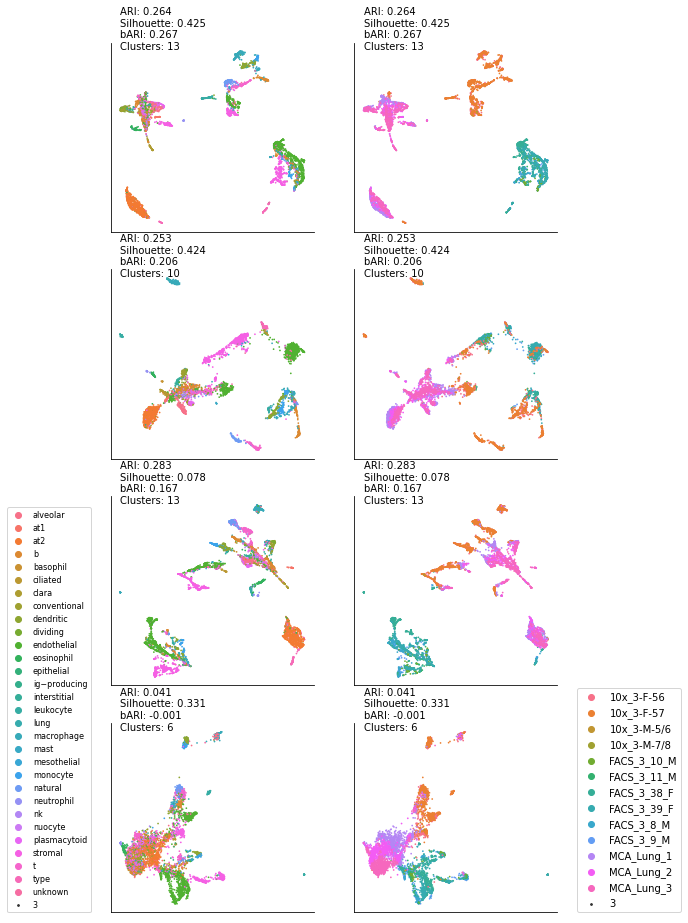

In [13]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1)) 

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot((total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_log(total_data), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_total20000(total_data), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_log(df_total20000(total_data)), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

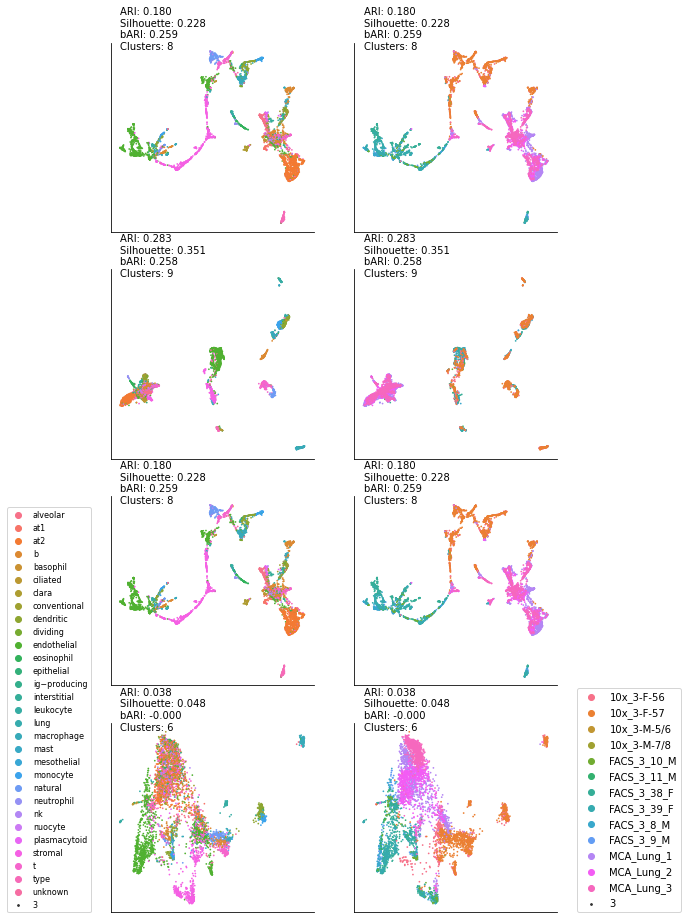

In [14]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

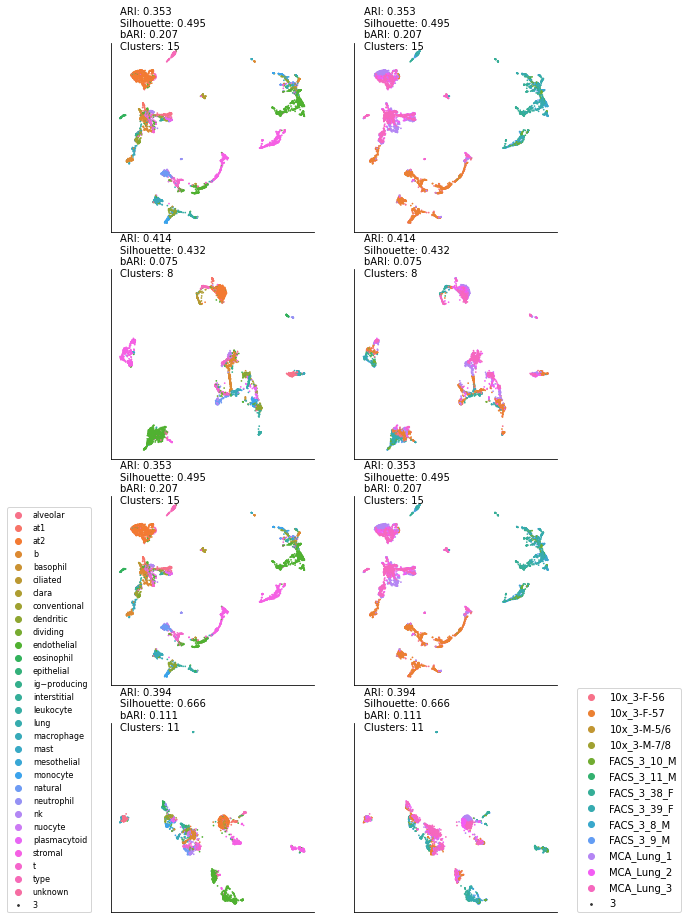

In [15]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

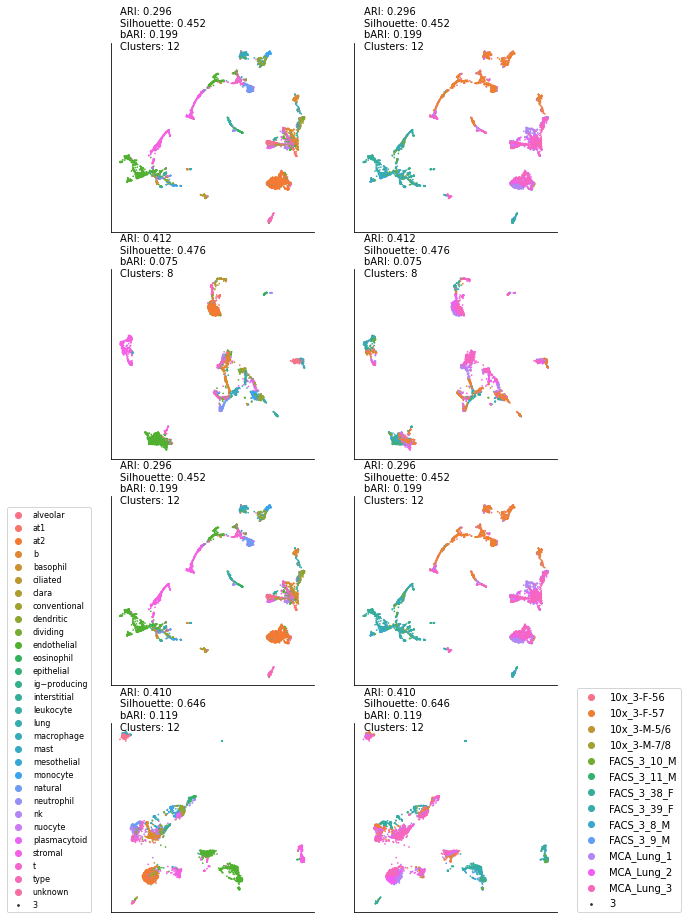

In [16]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

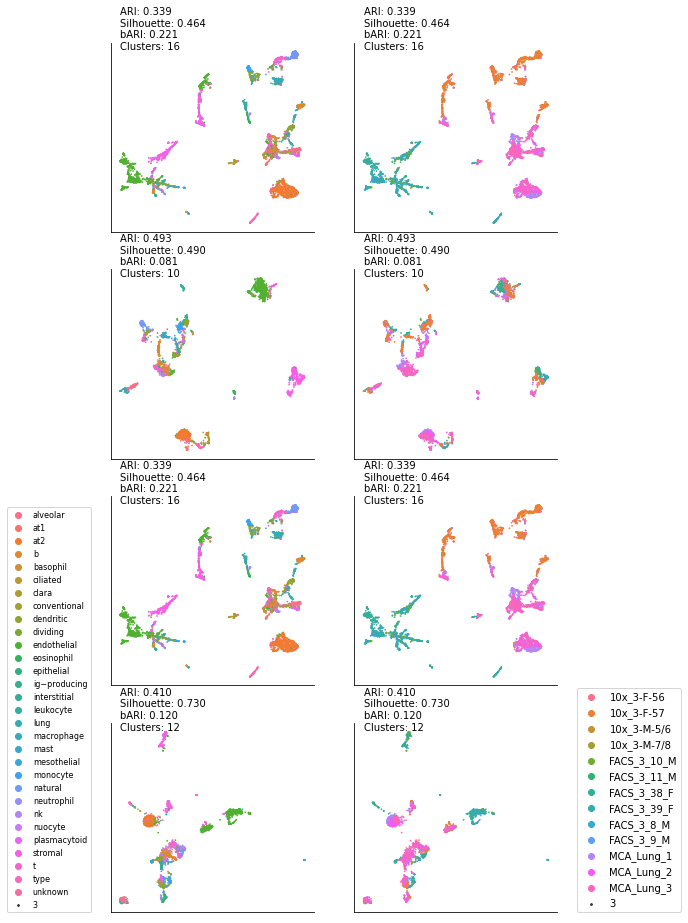

In [17]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

# Liver

In [4]:
ORGAN = 'Liver'

tabula_file_list = glob.glob("../data/tabular_muris/00_facs_raw_data/FACS/*"+ORGAN+"*.csv")
print(tabula_file_list)

tabula_10xfile_list = glob.glob("../data/tabular_muris/01_droplet_raw_data/droplet/*"+ORGAN+"*")
print(tabula_10xfile_list)

# Tabula data load
#
tabula_labels = []
tabula_data = pd.DataFrame()
for ff in tabula_file_list:
    data = pd.read_csv(ff, sep=',', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    tabula_data = pd.concat([tabula_data, data.iloc[c,]], axis=0)
    tabula_labels += [ff.rstrip('-counts.csv').split('/')[-1]] * data.shape[0]
    print(tabula_data.shape)

tabula_labels_set = set(tabula_labels)

# Tabula label load
#
annot_label = pd.read_csv('../data/tabular_muris/00_facs_raw_data/annotations_FACS.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_data.index)
m = annot_label.filter(com, axis=0)
tabula_data = tabula_data.filter(com, axis=0)
tabula_data = pd.concat([tabula_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue = tabula_data['tissue']
tabula_labels = tabula_data['cell_ontology_class']
tissue = tissue.values.tolist()
tabula_labels = tabula_labels.values.tolist()

tabula_data.pop('cell_ontology_class')
tabula_data.pop('tissue')
tabula_data.pop('zsGreen_transgene')
print(set(tabula_labels))

# Tabula 10x data load
#
tabula_10x_batches = []
tabula_10x_data = pd.DataFrame()
for ff in tabula_10xfile_list:
    data = scanpy.read_10x_mtx(ff)
    data = data.to_df()
    prefix_cell = ff.split('-')[1]
    data.index = [prefix_cell +'_'+x.split('-')[0] for x in data.index]
    tabula_10x_data = pd.concat([tabula_10x_data, data], axis=0)
    tabula_10x_batches += [ff.split('/')[-1].split('-')[1]] * data.shape[0]
    print(tabula_10x_data.shape)

# Tabula 10x label load
#
annot_label = pd.read_csv('../data/tabular_muris/01_droplet_raw_data/annotations_droplet.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_10x_data.index)
m = annot_label.filter(com, axis=0)
tabula_10x_data = tabula_10x_data.filter(com, axis=0)
tabula_10x_data = pd.concat([tabula_10x_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue_10x = tabula_10x_data['tissue']
tabula_10x_labels = tabula_10x_data['cell_ontology_class']
tissue_10x = tissue_10x.values.tolist()
tabula_10x_labels = tabula_10x_labels.values.tolist()

tabula_10x_data.pop('cell_ontology_class')
tabula_10x_data.pop('tissue')
tabula_10x_data.pop('zsGreen_transgene')
print(set(tabula_10x_labels))


# MCA load
#
mca_file_list = glob.glob("../dataset/MCA/mousecellatlas/*"+ORGAN+"*.txt")
print((mca_file_list))

mca_labels = []
mca_data = pd.DataFrame()
for ff in mca_file_list:
    data = pd.read_csv(ff, sep='\s+', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    data = data.iloc[c,]
    # use gene set from tabula_data (intersection with tabula_data)
    common = tabula_data.columns.intersection(data.columns)
    data.sort_index(axis=1, inplace=True)
    data = data.filter(common, axis=1)
    mca_data = pd.concat([mca_data, data], axis=0)
    mca_labels += [ff.split('/')[-1].split('_')[1]] * data.shape[0]
mca_data.replace(np.nan,0)
mca_label_set = set(mca_labels)
print(mca_label_set)

annot_label = pd.read_csv("../dataset/MCA/mousecellatlas/MCA_CellAssignments.csv", sep=',', index_col=1, header=0)
#print(annot_label['Annotation'])
com = annot_label['Annotation'].index.intersection(mca_data.index)
m = annot_label.filter(com, axis=0)

mca_data = mca_data.filter(com, axis=0)
mca_data = pd.concat([mca_data, m[['Tissue','Annotation','Batch']]],axis =1)

mca_tissue = mca_data['Tissue']
mca_labels = mca_data['Annotation']
mca_blabels = mca_data['Batch']
mca_tissue = mca_tissue.values.tolist()
mca_labels = mca_labels.values.tolist()
mca_blabels = mca_blabels.values.tolist()

mca_data.pop('Tissue')
mca_data.pop('Annotation')
mca_data.pop('Batch')
print(set(list(mca_labels)))
print(set(mca_tissue))

total_data = pd.concat([tabula_data, tabula_10x_data, mca_data], axis=0)
labels = tissue + tissue_10x + mca_tissue #mca_labels
labels_cell = tabula_labels + tabula_10x_labels + mca_labels #mca_labels
blabels = ['FACS_'+x.split('.')[2] for x in tabula_data.index] + ['10x_'+mouse_dic['_'.join(x.split('_')[0:3])] for x in tabula_10x_data.index] + ['MCA_'+x for x in (mca_blabels)]
total_data = total_data.replace(np.NaN,0)
print('\nSummary')
print(total_data.shape)
print(set(labels))
print(set(labels_cell))
print(set(blabels))

['../data/tabular_muris/00_facs_raw_data/FACS/Liver-counts.csv']
['../data/tabular_muris/01_droplet_raw_data/droplet/Liver-10X_P7_0', '../data/tabular_muris/01_droplet_raw_data/droplet/Liver-10X_P4_2', '../data/tabular_muris/01_droplet_raw_data/droplet/Liver-10X_P7_1']
(981, 23433)
{'B cell', 'hepatocyte', 'Kupffer cell', 'natural killer cell', 'endothelial cell of hepatic sinusoid'}
(596, 23433)
(1602, 23433)
(1924, 23433)
{'endothelial cell', 'hepatocyte'}
['../dataset/MCA/mousecellatlas/GSM2906428_Liver2_dge.txt', '../dataset/MCA/mousecellatlas/GSM2906427_Liver1_dge.txt']
{'Liver1', 'Liver2'}
{'Epithelia cell_Spp1 high(Liver)', 'Dendritic cell_Cst3 high(Liver)', 'Endothelial cell(Liver)', 'Dendritic cell_Siglech high(Liver)', 'Kuppfer cell(Liver)', 'Erythroblast_Hbb-bs high(Liver)', 'Periportal (PP) hepatocyte(Liver)', 'Hepatocyte_Fabp1 high(Liver)', 'T cell_Gzma high(Liver)', 'Macrophage_Chil3 high(Liver)', 'Hepatocyte_mt-Nd4 high(Liver)', 'Epithelial cell(Liver)', 'Neutrophil_Ngp 

In [5]:
new_labels = [x.split('_')[0].split('(')[0].lower().rstrip('s').split(' ')[0] for x in labels_cell]
print(set(new_labels))

{'kuppfer', 'dendritic', 't', 'pericentral', 'b', 'macrophage', 'kupffer', 'neutrophil', 'epithelia', 'epithelial', 'hepatocyte', 'periportal', 'granulocyte', 'endothelial', 'stromal', 'erythroblast', 'natural'}


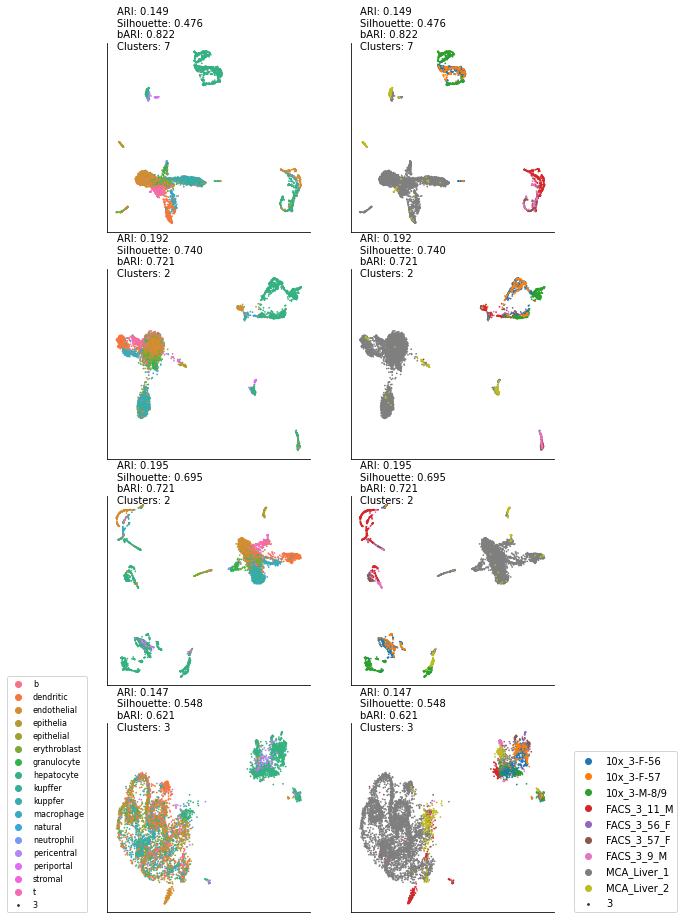

In [6]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1)) 

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot((total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_log(total_data), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_total20000(total_data), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_log(df_total20000(total_data)), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

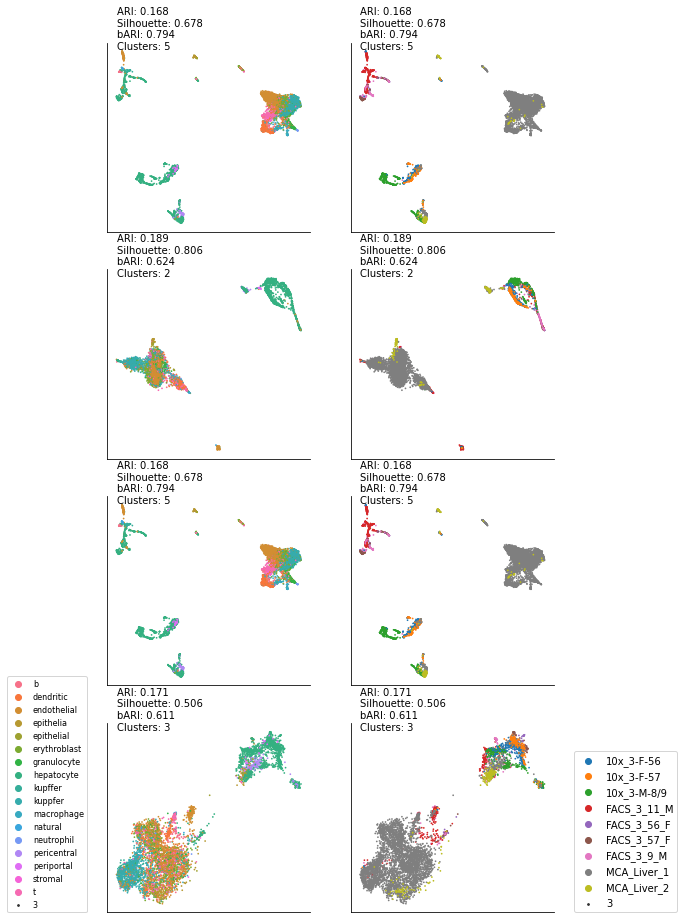

In [7]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

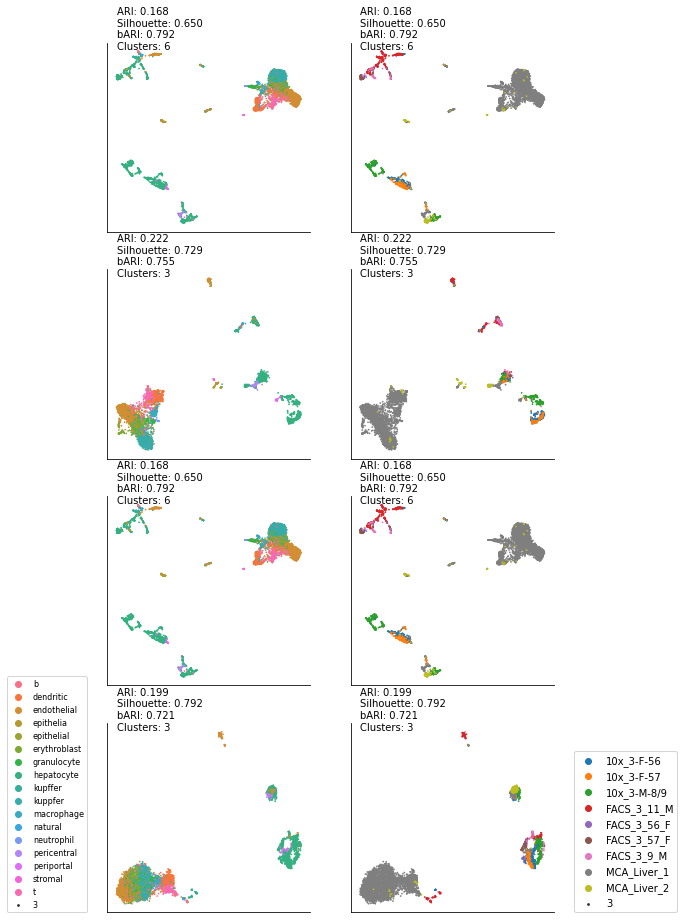

In [8]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

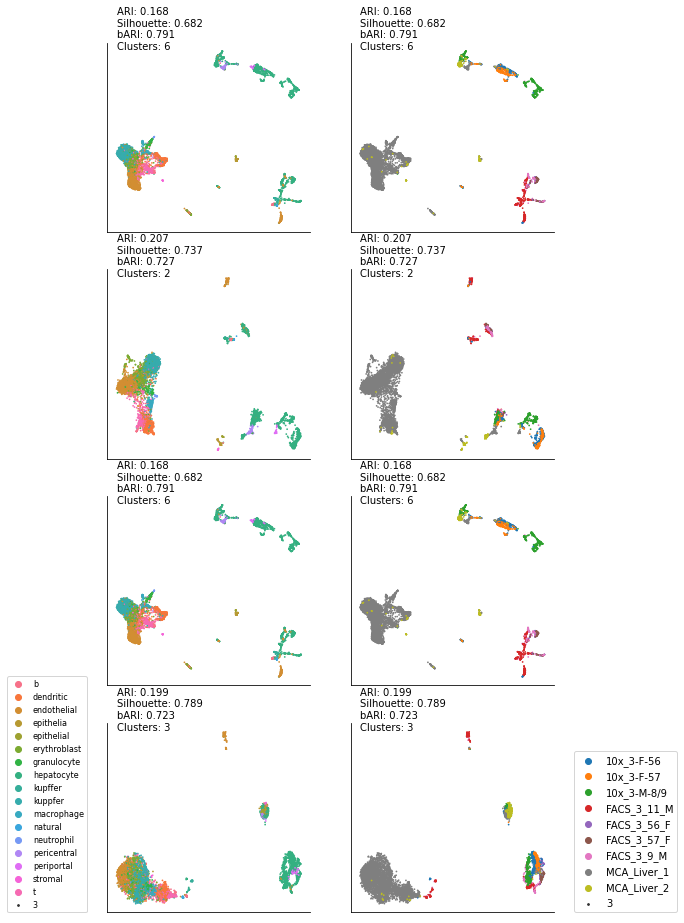

In [9]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

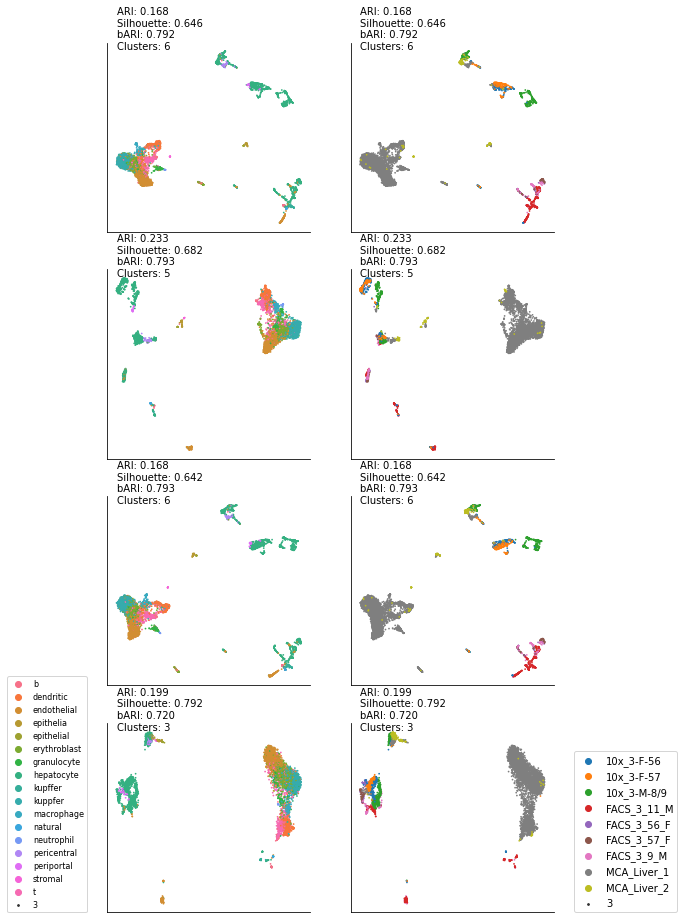

In [10]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

# Thymus

In [11]:
ORGAN = 'Thym'

tabula_file_list = glob.glob("../data/tabular_muris/00_facs_raw_data/FACS/*"+ORGAN+"*.csv")
print(tabula_file_list)

tabula_10xfile_list = glob.glob("../data/tabular_muris/01_droplet_raw_data/droplet/*"+ORGAN+"*")
print(tabula_10xfile_list)

# Tabula data load
#
tabula_labels = []
tabula_data = pd.DataFrame()
for ff in tabula_file_list:
    data = pd.read_csv(ff, sep=',', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    tabula_data = pd.concat([tabula_data, data.iloc[c,]], axis=0)
    tabula_labels += [ff.rstrip('-counts.csv').split('/')[-1]] * data.shape[0]
    print(tabula_data.shape)

tabula_labels_set = set(tabula_labels)

# Tabula label load
#
annot_label = pd.read_csv('../data/tabular_muris/00_facs_raw_data/annotations_FACS.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_data.index)
m = annot_label.filter(com, axis=0)
tabula_data = tabula_data.filter(com, axis=0)
tabula_data = pd.concat([tabula_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue = tabula_data['tissue']
tabula_labels = tabula_data['cell_ontology_class']
tissue = tissue.values.tolist()
tabula_labels = tabula_labels.values.tolist()

tabula_data.pop('cell_ontology_class')
tabula_data.pop('tissue')
tabula_data.pop('zsGreen_transgene')
print(set(tabula_labels))

# Tabula 10x data load
#
sample_per_class = 1000

tabula_10x_batches = []
tabula_10x_data = pd.DataFrame()
for ff in tabula_10xfile_list:
    data = scanpy.read_10x_mtx(ff)
    c = list(range(len(data.obs)))
    random.shuffle(c)
    c = c[:sample_per_class]
    data = data[c,]
    data = data.to_df()
    prefix_cell = ff.split('-')[1]
    data.index = [prefix_cell +'_'+x.split('-')[0] for x in data.index]
    tabula_10x_data = pd.concat([tabula_10x_data, data], axis=0)
    tabula_10x_batches += [ff.split('/')[-1].split('-')[1]] * data.shape[0]
    print(tabula_10x_data.shape)

# Tabula 10x label load
#
annot_label = pd.read_csv('../data/tabular_muris/01_droplet_raw_data/annotations_droplet.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_10x_data.index)
m = annot_label.filter(com, axis=0)
tabula_10x_data = tabula_10x_data.filter(com, axis=0)
tabula_10x_data = pd.concat([tabula_10x_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue_10x = tabula_10x_data['tissue']
tabula_10x_labels = tabula_10x_data['cell_ontology_class']
tissue_10x = tissue_10x.values.tolist()
tabula_10x_labels = tabula_10x_labels.values.tolist()

tabula_10x_data.pop('cell_ontology_class')
tabula_10x_data.pop('tissue')
tabula_10x_data.pop('zsGreen_transgene')
print(set(tabula_10x_labels))

# MCA load
#
mca_file_list = glob.glob("../dataset/MCA/mousecellatlas/*"+ORGAN+"*.txt")
print((mca_file_list))

mca_labels = []
mca_data = pd.DataFrame()
for ff in mca_file_list:
    data = pd.read_csv(ff, sep='\s+', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    random.shuffle(c)
    c = c[:sample_per_class]
    data = data.iloc[c,]
    # use gene set from tabula_data (intersection with tabula_data)
    common = tabula_data.columns.intersection(data.columns)
    data.sort_index(axis=1, inplace=True)
    data = data.filter(common, axis=1)
    mca_data = pd.concat([mca_data, data], axis=0)
    mca_labels += [ff.split('/')[-1].split('_')[1]] * data.shape[0]
mca_data.replace(np.nan,0)
mca_label_set = set(mca_labels)
print(mca_label_set)

annot_label = pd.read_csv("../dataset/MCA/mousecellatlas/MCA_CellAssignments.csv", sep=',', index_col=1, header=0)
#print(annot_label['Annotation'])
com = annot_label['Annotation'].index.intersection(mca_data.index)
m = annot_label.filter(com, axis=0)

mca_data = mca_data.filter(com, axis=0)
mca_data = pd.concat([mca_data, m[['Tissue','Annotation','Batch']]],axis =1)

mca_tissue = mca_data['Tissue']
mca_labels = mca_data['Annotation']
mca_blabels = mca_data['Batch']
mca_tissue = mca_tissue.values.tolist()
mca_labels = mca_labels.values.tolist()
mca_blabels = mca_blabels.values.tolist()

mca_data.pop('Tissue')
mca_data.pop('Annotation')
mca_data.pop('Batch')
print(set(list(mca_labels)))
print(set(mca_tissue))

total_data = pd.concat([tabula_data, tabula_10x_data, mca_data], axis=0)
labels = tissue + tissue_10x + mca_tissue #mca_labels
labels_cell = tabula_labels + tabula_10x_labels + mca_labels #mca_labels
blabels = ['FACS_'+x.split('.')[2] for x in tabula_data.index] + ['10x_'+mouse_dic['_'.join(x.split('_')[0:3])] for x in tabula_10x_data.index] + ['MCA_'+x for x in (mca_blabels)]
total_data = total_data.replace(np.NaN,0)
print('\nSummary')
print(total_data.shape)
print(set(labels))
print(set(labels_cell))
print(set(blabels))

['../data/tabular_muris/00_facs_raw_data/FACS/Thymus-counts.csv']
['../data/tabular_muris/01_droplet_raw_data/droplet/Thymus-10X_P7_11']
(1580, 23433)
{'mesenchymal stem cell', 'T cell'}
(1000, 23433)
{'T cell', 'stromal cell'}
['../dataset/MCA/mousecellatlas/GSM2906476_Thymus2_dge.txt', '../dataset/MCA/mousecellatlas/GSM2906475_Thymus1_dge.txt']
{'Thymus1', 'Thymus2'}
{'T cell_Ms4a4b high(Thymus)', 'Proliferating thymocyte(Thymus)', 'B cell(Thymus)', 'Pre T cell(Thymus)', 'gdT cell (Thymus)', 'T cell_Id2 high(Thymus)', 'abT cell(Thymus)', 'DPT cell(Thymus)'}
{'Thymus'}

Summary
(3120, 23432)
{'Thymus'}
{'T cell_Ms4a4b high(Thymus)', 'T cell', 'stromal cell', 'Proliferating thymocyte(Thymus)', 'mesenchymal stem cell', 'B cell(Thymus)', 'Pre T cell(Thymus)', 'gdT cell (Thymus)', 'T cell_Id2 high(Thymus)', 'DPT cell(Thymus)', 'abT cell(Thymus)'}
{'FACS_3_39_F', 'FACS_3_11_M', 'FACS_3_9_M', 'MCA_Thymus_1', 'FACS_3_8_M', 'FACS_3_38_F', '10x_3-F-56'}


In [12]:
new_labels = [x.split('_')[0].split('(')[0].lower().rstrip('s').split(' ')[0] for x in labels_cell]
print(set(new_labels))

{'mesenchymal', 't', 'dpt', 'b', 'abt', 'pre', 'proliferating', 'stromal', 'gdt'}


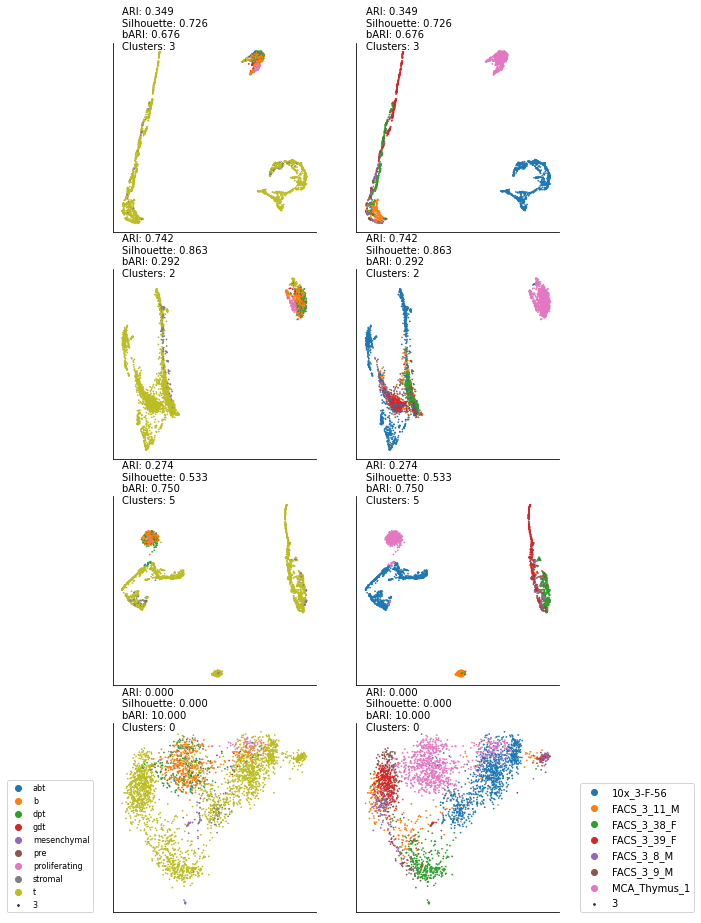

In [13]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1)) 

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot((total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_log(total_data), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_total20000(total_data), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_log(df_total20000(total_data)), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

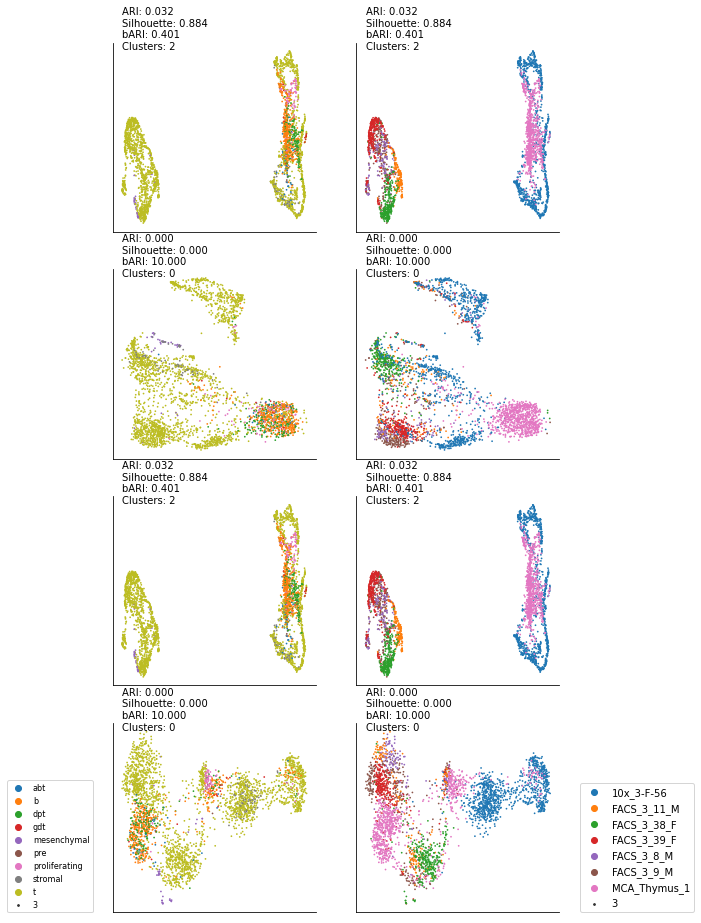

In [14]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

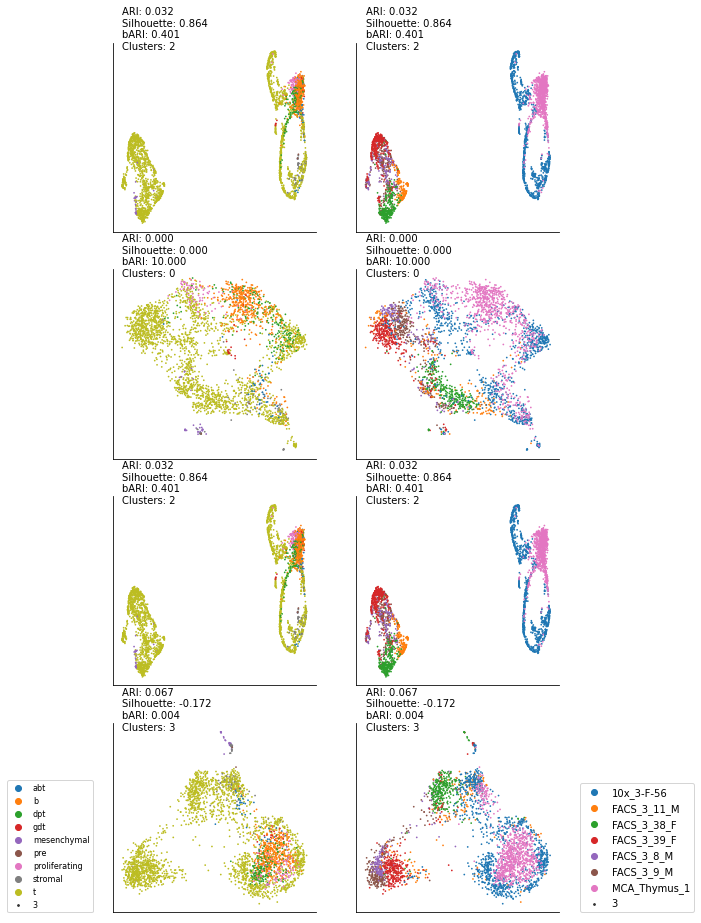

In [15]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

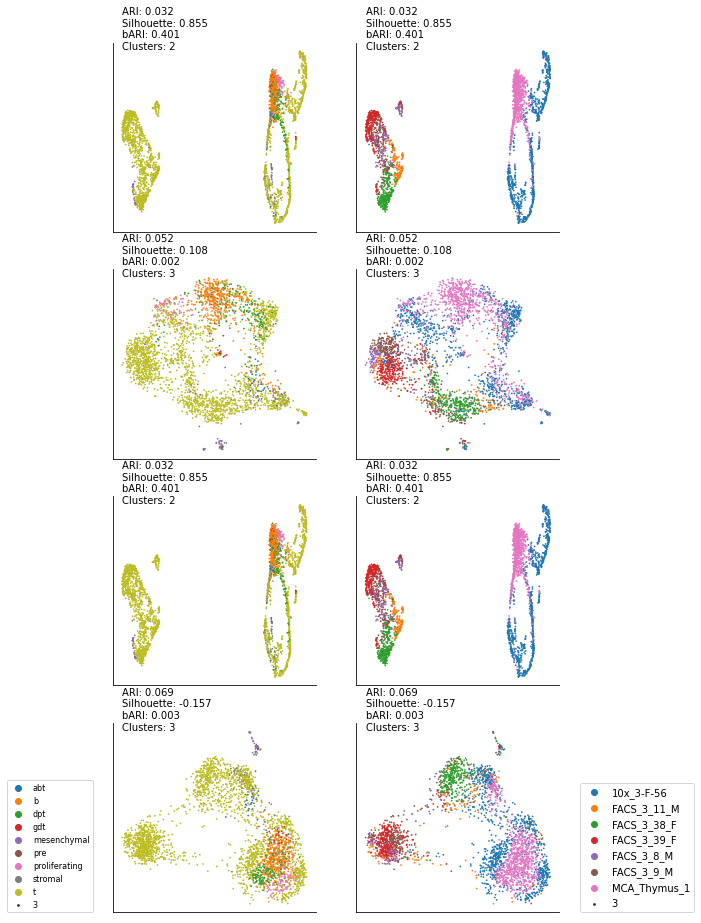

In [16]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

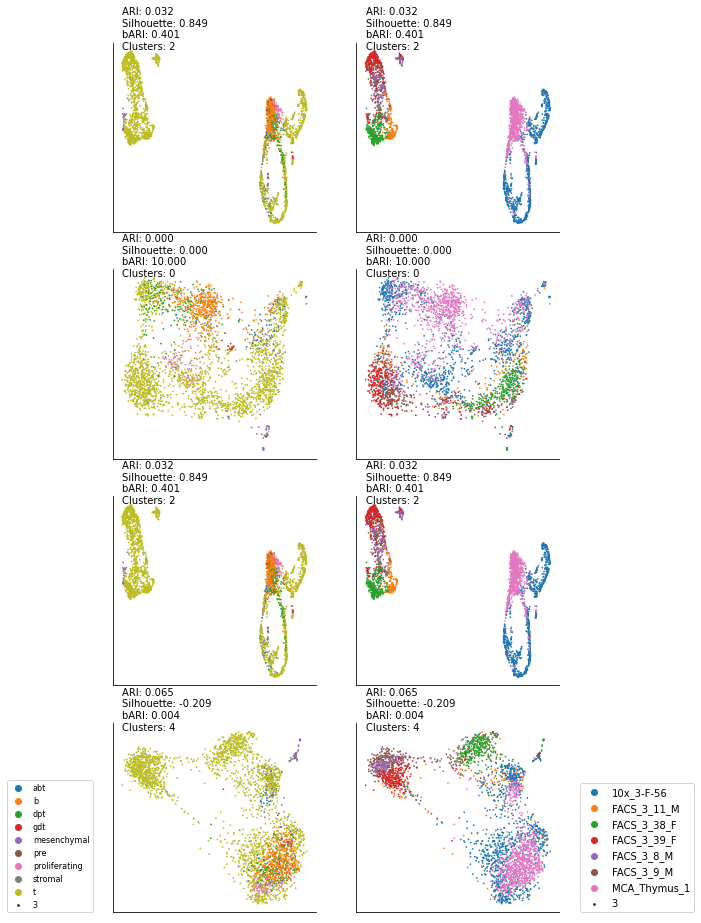

In [17]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

# Spleen

In [18]:
ORGAN = 'Splee'

tabula_file_list = glob.glob("../data/tabular_muris/00_facs_raw_data/FACS/*"+ORGAN+"*.csv")
print(tabula_file_list)

tabula_10xfile_list = glob.glob("../data/tabular_muris/01_droplet_raw_data/droplet/*"+ORGAN+"*")
print(tabula_10xfile_list)

# Tabula data load
#
tabula_labels = []
tabula_data = pd.DataFrame()
for ff in tabula_file_list:
    data = pd.read_csv(ff, sep=',', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    tabula_data = pd.concat([tabula_data, data.iloc[c,]], axis=0)
    tabula_labels += [ff.rstrip('-counts.csv').split('/')[-1]] * data.shape[0]
    print(tabula_data.shape)

tabula_labels_set = set(tabula_labels)

# Tabula label load
#
annot_label = pd.read_csv('../data/tabular_muris/00_facs_raw_data/annotations_FACS.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_data.index)
m = annot_label.filter(com, axis=0)
tabula_data = tabula_data.filter(com, axis=0)
tabula_data = pd.concat([tabula_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue = tabula_data['tissue']
tabula_labels = tabula_data['cell_ontology_class']
tissue = tissue.values.tolist()
tabula_labels = tabula_labels.values.tolist()

tabula_data.pop('cell_ontology_class')
tabula_data.pop('tissue')
tabula_data.pop('zsGreen_transgene')
print(set(tabula_labels))

# Tabula 10x data load
#
sample_per_class = 1000

tabula_10x_batches = []
tabula_10x_data = pd.DataFrame()
for ff in tabula_10xfile_list:
    data = scanpy.read_10x_mtx(ff)
    c = list(range(len(data.obs)))
    random.shuffle(c)
    c = c[:sample_per_class]
    data = data[c,]
    data = data.to_df()
    prefix_cell = ff.split('-')[1]
    data.index = [prefix_cell +'_'+x.split('-')[0] for x in data.index]
    tabula_10x_data = pd.concat([tabula_10x_data, data], axis=0)
    tabula_10x_batches += [ff.split('/')[-1].split('-')[1]] * data.shape[0]
    print(tabula_10x_data.shape)

# Tabula 10x label load
#
annot_label = pd.read_csv('../data/tabular_muris/01_droplet_raw_data/annotations_droplet.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_10x_data.index)
m = annot_label.filter(com, axis=0)
tabula_10x_data = tabula_10x_data.filter(com, axis=0)
tabula_10x_data = pd.concat([tabula_10x_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue_10x = tabula_10x_data['tissue']
tabula_10x_labels = tabula_10x_data['cell_ontology_class']
tissue_10x = tissue_10x.values.tolist()
tabula_10x_labels = tabula_10x_labels.values.tolist()

tabula_10x_data.pop('cell_ontology_class')
tabula_10x_data.pop('tissue')
tabula_10x_data.pop('zsGreen_transgene')
print(set(tabula_10x_labels))

# MCA load
#
mca_file_list = glob.glob("../dataset/MCA/mousecellatlas/*"+ORGAN+"*.txt")
print((mca_file_list))

mca_labels = []
mca_data = pd.DataFrame()
for ff in mca_file_list:
    data = pd.read_csv(ff, sep='\s+', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    random.shuffle(c)
    c = c[:sample_per_class]
    data = data.iloc[c,]
    # use gene set from tabula_data (intersection with tabula_data)
    common = tabula_data.columns.intersection(data.columns)
    data.sort_index(axis=1, inplace=True)
    data = data.filter(common, axis=1)
    mca_data = pd.concat([mca_data, data], axis=0)
    mca_labels += [ff.split('/')[-1].split('_')[1]] * data.shape[0]
mca_data.replace(np.nan,0)
mca_label_set = set(mca_labels)
print(mca_label_set)

annot_label = pd.read_csv("../dataset/MCA/mousecellatlas/MCA_CellAssignments.csv", sep=',', index_col=1, header=0)
#print(annot_label['Annotation'])
com = annot_label['Annotation'].index.intersection(mca_data.index)
m = annot_label.filter(com, axis=0)

mca_data = mca_data.filter(com, axis=0)
mca_data = pd.concat([mca_data, m[['Tissue','Annotation','Batch']]],axis =1)

mca_tissue = mca_data['Tissue']
mca_labels = mca_data['Annotation']
mca_blabels = mca_data['Batch']
mca_tissue = mca_tissue.values.tolist()
mca_labels = mca_labels.values.tolist()
mca_blabels = mca_blabels.values.tolist()

mca_data.pop('Tissue')
mca_data.pop('Annotation')
mca_data.pop('Batch')
print(set(list(mca_labels)))
print(set(mca_tissue))

total_data = pd.concat([tabula_data, tabula_10x_data, mca_data], axis=0)
labels = tissue + tissue_10x + mca_tissue #mca_labels
labels_cell = tabula_labels + tabula_10x_labels + mca_labels #mca_labels
blabels = ['FACS_'+x.split('.')[2] for x in tabula_data.index] + ['10x_'+mouse_dic['_'.join(x.split('_')[0:3])] for x in tabula_10x_data.index] + ['MCA_'+x for x in (mca_blabels)]
total_data = total_data.replace(np.NaN,0)
print('\nSummary')
print(total_data.shape)
print(set(labels))
print(set(labels_cell))
print(set(blabels))

['../data/tabular_muris/00_facs_raw_data/FACS/Spleen-counts.csv']
['../data/tabular_muris/01_droplet_raw_data/droplet/Spleen-10X_P7_6', '../data/tabular_muris/01_droplet_raw_data/droplet/Spleen-10X_P4_7']
(1718, 23433)
{'B cell', 'myeloid cell', 'T cell'}
(1000, 23433)
(2000, 23433)
{'B cell', 'macrophage', 'T cell', 'dendritic cell'}
['../dataset/MCA/mousecellatlas/GSM2906471_Spleen_dge.txt']
{'Spleen'}
{'Macrophage(Spleen)', 'Monocyte(Spleen)', 'T cell(Spleen)', 'Erythroblast(Spleen)', 'Granulocyte(Spleen)', 'Plasma cell(Spleen)', 'Dendritic cell_S100a4 high(Spleen)', 'NK cell(Spleen)', 'Dendritic cell_Siglech high(Spleen)', 'Marginal zone B cell(Spleen)', 'Neutrophil(Spleen)'}
{'Spleen'}

Summary
(4496, 23432)
{'Spleen'}
{'Macrophage(Spleen)', 'T cell(Spleen)', 'myeloid cell', 'T cell', 'Monocyte(Spleen)', 'Plasma cell(Spleen)', 'Granulocyte(Spleen)', 'Dendritic cell_S100a4 high(Spleen)', 'Neutrophil(Spleen)', 'macrophage', 'NK cell(Spleen)', 'Dendritic cell_Siglech high(Spleen)', '

In [19]:
new_labels = [x.split('_')[0].split('(')[0].lower().rstrip('s').split(' ')[0] for x in labels_cell]
print(set(new_labels))

{'plasma', 'dendritic', 't', 'nk', 'b', 'macrophage', 'marginal', 'neutrophil', 'myeloid', 'granulocyte', 'monocyte', 'erythroblast'}


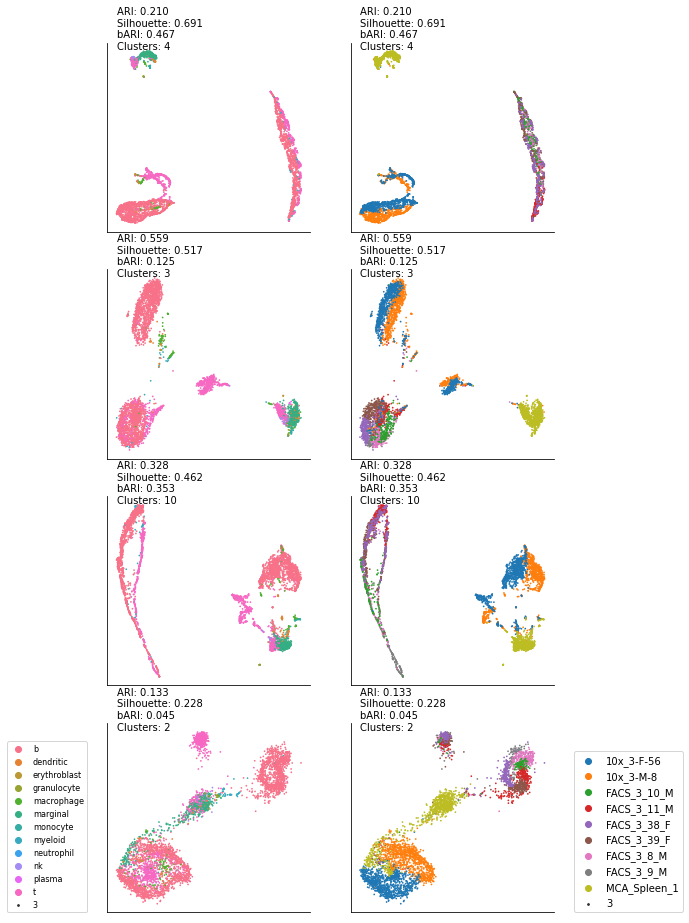

In [20]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1)) 

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot((total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_log(total_data), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_total20000(total_data), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_log(df_total20000(total_data)), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

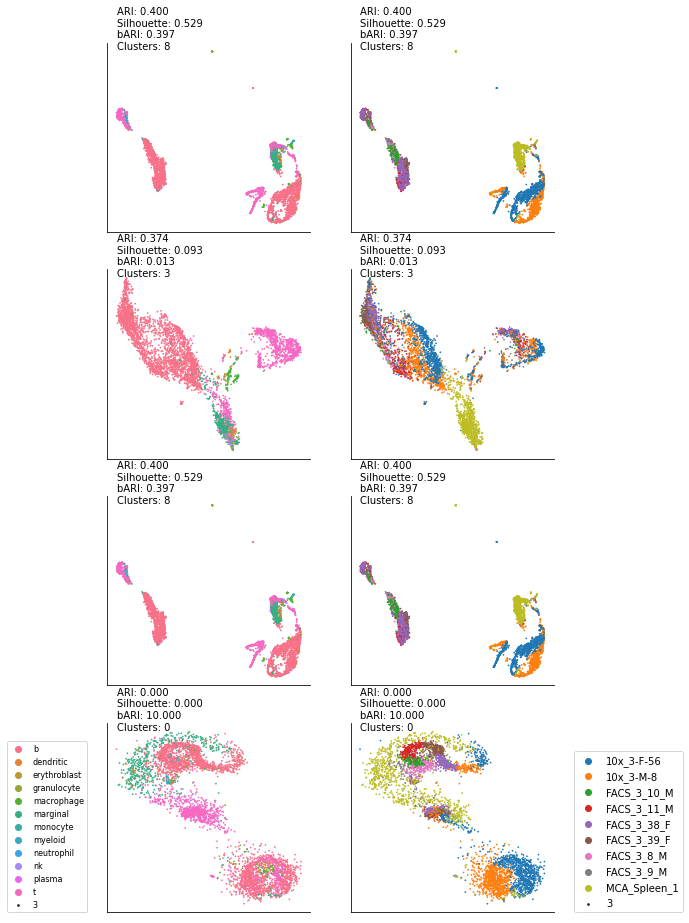

In [21]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

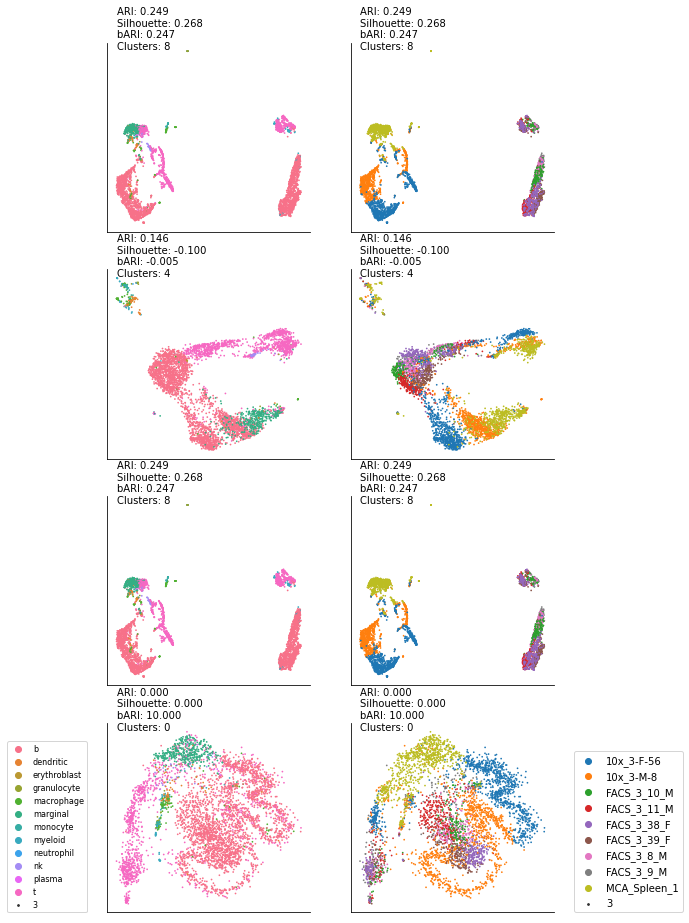

In [22]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

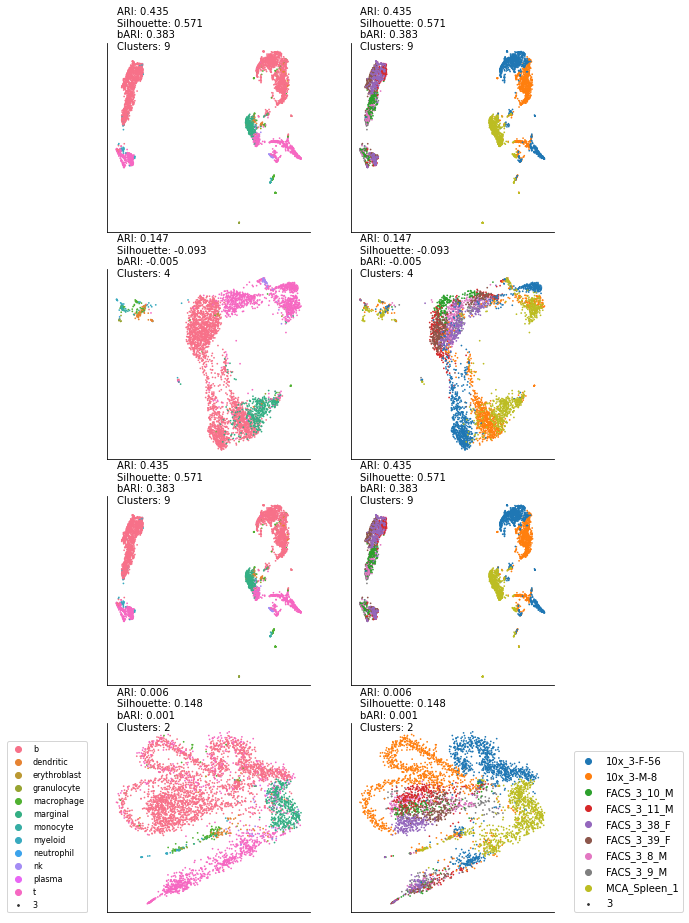

In [23]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

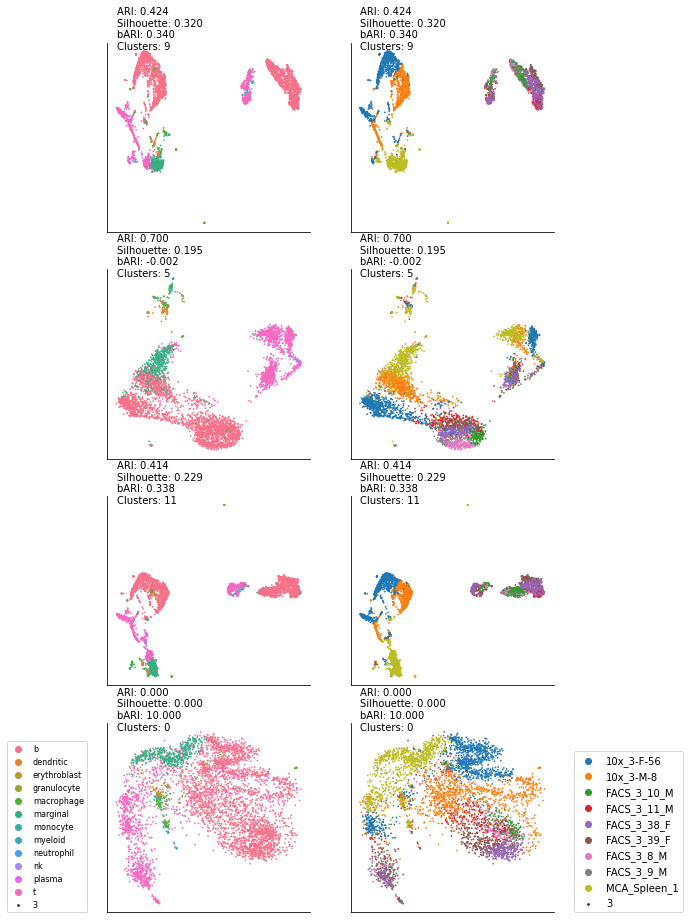

In [24]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

# Marrow

In [4]:
ORGAN = 'Marrow'

tabula_file_list = glob.glob("../data/tabular_muris/00_facs_raw_data/FACS/*"+ORGAN+"*.csv")
print(tabula_file_list)

tabula_10xfile_list = glob.glob("../data/tabular_muris/01_droplet_raw_data/droplet/*"+ORGAN+"*")
print(tabula_10xfile_list)

sample_per_class = 1000

# Tabula data load
#
tabula_labels = []
tabula_data = pd.DataFrame()
for ff in tabula_file_list:
    data = pd.read_csv(ff, sep=',', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    random.shuffle(c)
    c = c[:sample_per_class]
    data = data.iloc[c,]
    tabula_data = pd.concat([tabula_data, data], axis=0)
    tabula_labels += [ff.rstrip('-counts.csv').split('/')[-1]] * data.shape[0]
    print(tabula_data.shape)

tabula_labels_set = set(tabula_labels)

# Tabula label load
#
annot_label = pd.read_csv('../data/tabular_muris/00_facs_raw_data/annotations_FACS.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_data.index)
m = annot_label.filter(com, axis=0)
tabula_data = tabula_data.filter(com, axis=0)
tabula_data = pd.concat([tabula_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue = tabula_data['tissue']
tabula_labels = tabula_data['cell_ontology_class']
tissue = tissue.values.tolist()
tabula_labels = tabula_labels.values.tolist()

tabula_data.pop('cell_ontology_class')
tabula_data.pop('tissue')
tabula_data.pop('zsGreen_transgene')
print(set(tabula_labels))

# Tabula 10x data load
#

tabula_10x_batches = []
tabula_10x_data = pd.DataFrame()
for ff in tabula_10xfile_list:
    data = scanpy.read_10x_mtx(ff)
    c = list(range(len(data.obs)))
    random.shuffle(c)
    c = c[:sample_per_class]
    data = data[c,]
    data = data.to_df()
    prefix_cell = ff.split('-')[1]
    data.index = [prefix_cell +'_'+x.split('-')[0] for x in data.index]
    tabula_10x_data = pd.concat([tabula_10x_data, data], axis=0)
    tabula_10x_batches += [ff.split('/')[-1].split('-')[1]] * data.shape[0]
    print(tabula_10x_data.shape)

# Tabula 10x label load
#
annot_label = pd.read_csv('../data/tabular_muris/01_droplet_raw_data/annotations_droplet.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_10x_data.index)
m = annot_label.filter(com, axis=0)
tabula_10x_data = tabula_10x_data.filter(com, axis=0)
tabula_10x_data = pd.concat([tabula_10x_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue_10x = tabula_10x_data['tissue']
tabula_10x_labels = tabula_10x_data['cell_ontology_class']
tissue_10x = tissue_10x.values.tolist()
tabula_10x_labels = tabula_10x_labels.values.tolist()

tabula_10x_data.pop('cell_ontology_class')
tabula_10x_data.pop('tissue')
tabula_10x_data.pop('zsGreen_transgene')
print(set(tabula_10x_labels))

# MCA load
#
mca_file_list = glob.glob("../dataset/MCA/mousecellatlas/*"+ORGAN+"*.txt")
print((mca_file_list))
sample_per_class = 500

mca_labels = []
mca_data = pd.DataFrame()
for ff in mca_file_list:
    data = pd.read_csv(ff, sep='\s+', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    random.shuffle(c)
    c = c[:sample_per_class]
    data = data.iloc[c,]
    # use gene set from tabula_data (intersection with tabula_data)
    common = tabula_data.columns.intersection(data.columns)
    data.sort_index(axis=1, inplace=True)
    data = data.filter(common, axis=1)
    mca_data = pd.concat([mca_data, data], axis=0)
    mca_labels += [ff.split('/')[-1].split('_')[1]] * data.shape[0]
mca_data.replace(np.nan,0)
mca_label_set = set(mca_labels)
print(mca_label_set)

annot_label = pd.read_csv("../dataset/MCA/mousecellatlas/MCA_CellAssignments.csv", sep=',', index_col=1, header=0)
#print(annot_label['Annotation'])
com = annot_label['Annotation'].index.intersection(mca_data.index)
m = annot_label.filter(com, axis=0)

mca_data = mca_data.filter(com, axis=0)
mca_data = pd.concat([mca_data, m[['Tissue','Annotation','Batch']]],axis =1)

mca_tissue = mca_data['Tissue']
mca_labels = mca_data['Annotation']
mca_blabels = mca_data['Batch']
mca_tissue = mca_tissue.values.tolist()
mca_labels = mca_labels.values.tolist()
mca_blabels = mca_blabels.values.tolist()

mca_data.pop('Tissue')
mca_data.pop('Annotation')
mca_data.pop('Batch')
print(set(list(mca_labels)))
print(set(mca_tissue))

total_data = pd.concat([tabula_data, tabula_10x_data, mca_data], axis=0)
labels = tissue + tissue_10x + mca_tissue #mca_labels
labels_cell = tabula_labels + tabula_10x_labels + mca_labels #mca_labels
blabels = ['FACS_'+x.split('.')[2] for x in tabula_data.index] + ['10x_'+mouse_dic['_'.join(x.split('_')[0:3])] for x in tabula_10x_data.index] + ['MCA_'+x for x in (mca_blabels)]
total_data = total_data.replace(np.NaN,0)
print('\nSummary')
print(total_data.shape)
print(set(labels))
print(set(labels_cell))
print(set(blabels))

['../data/tabular_muris/00_facs_raw_data/FACS/Marrow-counts.csv']
['../data/tabular_muris/01_droplet_raw_data/droplet/Marrow-10X_P7_2', '../data/tabular_muris/01_droplet_raw_data/droplet/Marrow-10X_P7_3']
(1000, 23433)
{'Fraction A pre-pro B cell', 'granulocyte', 'B cell', 'hematopoietic stem cell', 'monocyte', 'T cell', 'natural killer cell', 'neutrophil'}
(1000, 23433)
(2000, 23433)
{'Fraction A pre-pro B cell', 'erythrocyte', 'granulocyte', 'B cell', 'hematopoietic stem cell', 'monocyte', 'macrophage', 'T cell'}
['../dataset/MCA/mousecellatlas/GSM2906403_BoneMarrowcKit3_dge.txt', '../dataset/MCA/mousecellatlas/GSM2906396_BoneMarrow1_dge.txt', '../dataset/MCA/mousecellatlas/GSM2906402_BoneMarrowcKit2_dge.txt', '../dataset/MCA/mousecellatlas/GSM2906401_BoneMarrowcKit1_dge.txt', '../dataset/MCA/mousecellatlas/GSM2906400_BoneMarrow3_dge.txt', '../dataset/MCA/mousecellatlas/GSM2906399_BoneMarrow2_dge.txt', '../dataset/MCA/mousecellatlas/GSM2906404_Bone.Marrow.Mesenchyme_dge.txt']
{'BoneM

In [5]:
new_labels = [x.split('_')[0].split('(')[0].lower().rstrip('s').split(' ')[0] for x in labels_cell]
print(set(new_labels))

{'b', 'hematopoietic', 'natural', 'granulocyte', 'macrophage', 'eosinophil', 'erythroblast', 'neutrophil', 'msc', 'erythrocyte', 'fraction', 'multipotent', 'monocyte', 'osteoblast', 'dendritic', 'myoblast', 'fibroblast', 'pre-pro', 'basophil', 't', 'proerythrocyte', 'endothelial', 'megakaryocyte', 'cxcl12-abundant', 'mast', 'stromal'}


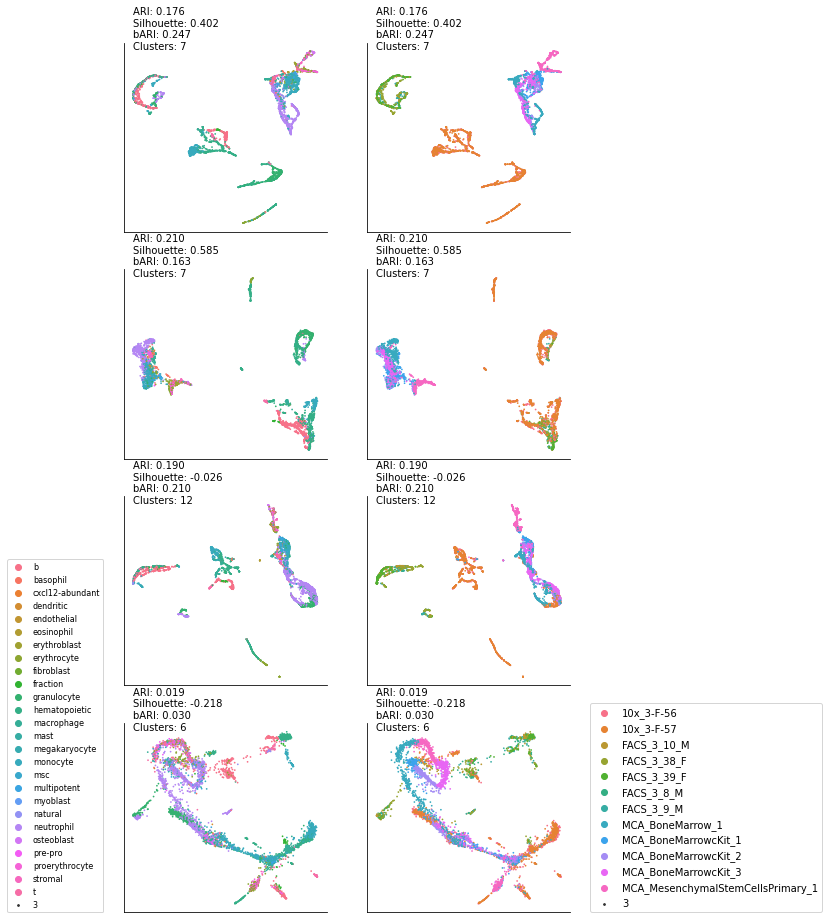

In [6]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1)) 

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot((total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_log(total_data), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_total20000(total_data), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_log(df_total20000(total_data)), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

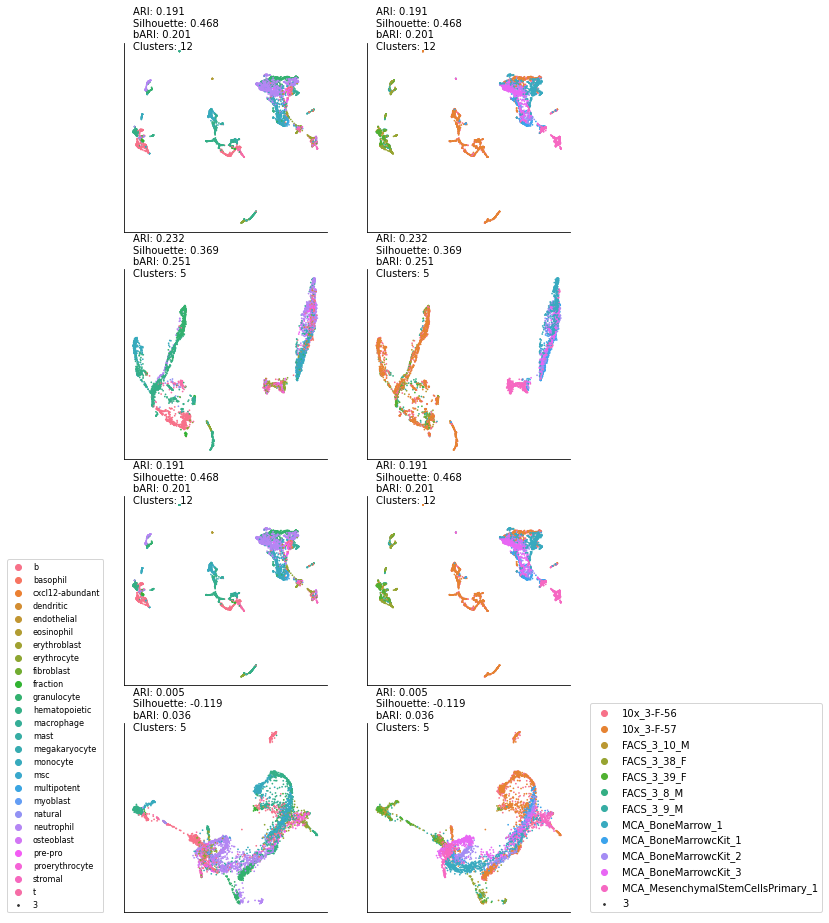

In [7]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

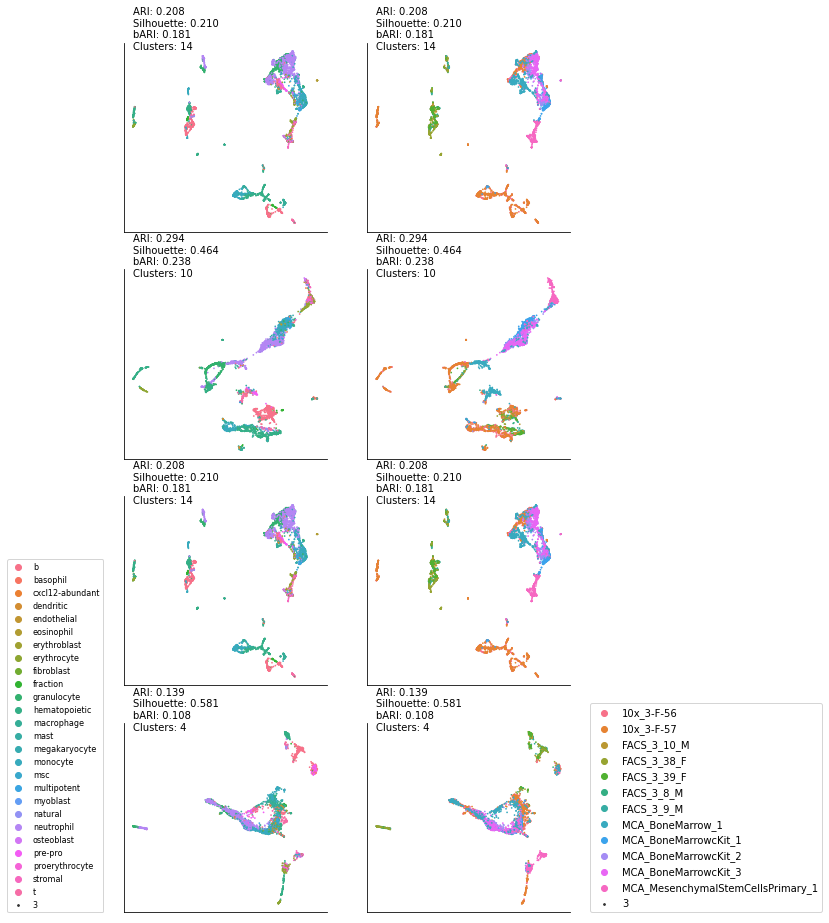

In [8]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

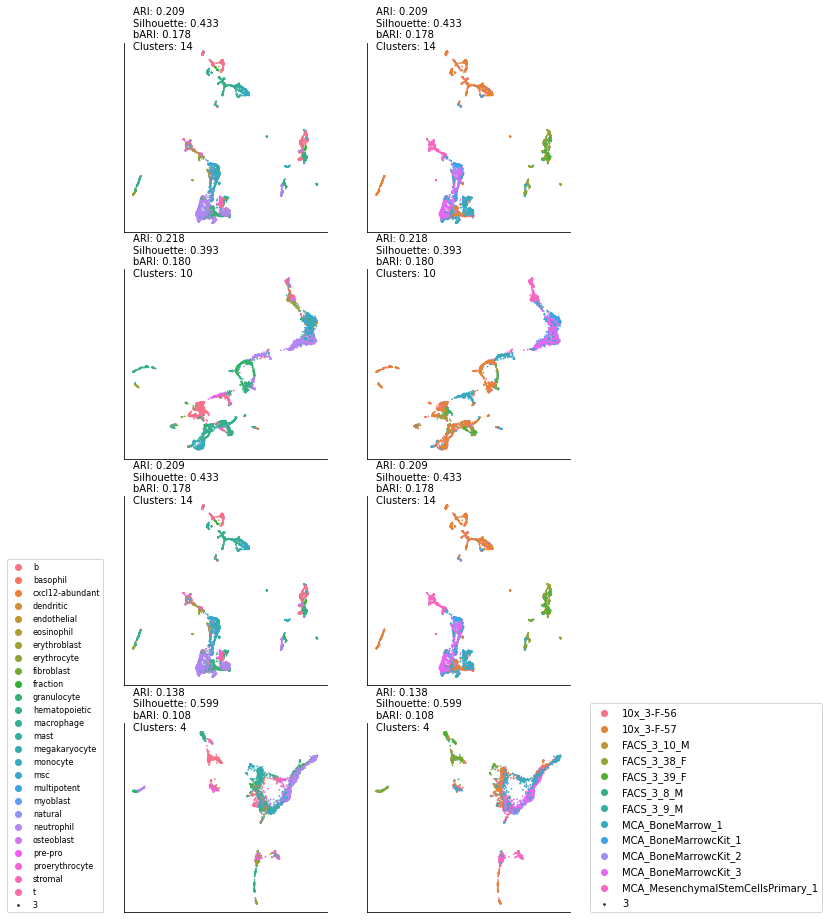

In [9]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

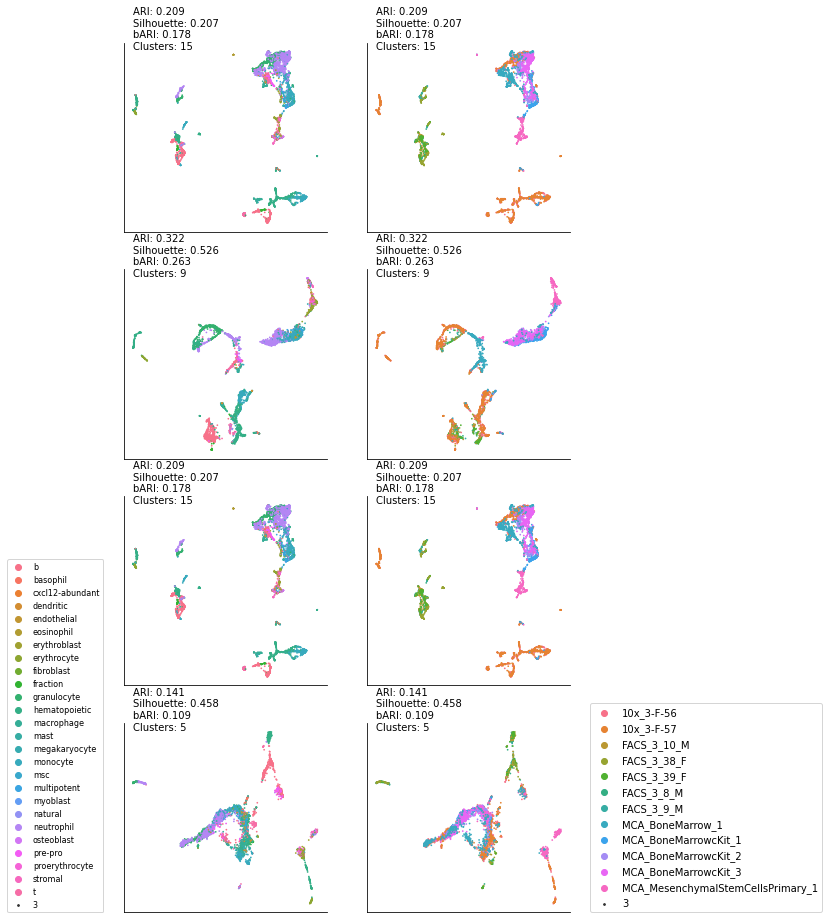

In [10]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

# Kidney

In [4]:
ORGAN = 'Kidney'

tabula_file_list = glob.glob("../data/tabular_muris/00_facs_raw_data/FACS/*"+ORGAN+"*.csv")
print(tabula_file_list)

tabula_10xfile_list = glob.glob("../data/tabular_muris/01_droplet_raw_data/droplet/*"+ORGAN+"*")
print(tabula_10xfile_list)

# Tabula data load
#
tabula_labels = []
tabula_data = pd.DataFrame()
for ff in tabula_file_list:
    data = pd.read_csv(ff, sep=',', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    tabula_data = pd.concat([tabula_data, data.iloc[c,]], axis=0)
    tabula_labels += [ff.rstrip('-counts.csv').split('/')[-1]] * data.shape[0]
    print(tabula_data.shape)

tabula_labels_set = set(tabula_labels)

# Tabula label load
#
annot_label = pd.read_csv('../data/tabular_muris/00_facs_raw_data/annotations_FACS.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_data.index)
m = annot_label.filter(com, axis=0)
tabula_data = tabula_data.filter(com, axis=0)
tabula_data = pd.concat([tabula_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue = tabula_data['tissue']
tabula_labels = tabula_data['cell_ontology_class']
tissue = tissue.values.tolist()
tabula_labels = tabula_labels.values.tolist()

tabula_data.pop('cell_ontology_class')
tabula_data.pop('tissue')
tabula_data.pop('zsGreen_transgene')
print(set(tabula_labels))

# Tabula 10x data load
#
sample_per_class = 1000

tabula_10x_batches = []
tabula_10x_data = pd.DataFrame()
for ff in tabula_10xfile_list:
    data = scanpy.read_10x_mtx(ff)
    c = list(range(len(data.obs)))
    random.shuffle(c)
    c = c[:sample_per_class]
    data = data[c,]
    data = data.to_df()
    prefix_cell = ff.split('-')[1]
    data.index = [prefix_cell +'_'+x.split('-')[0] for x in data.index]
    tabula_10x_data = pd.concat([tabula_10x_data, data], axis=0)
    tabula_10x_batches += [ff.split('/')[-1].split('-')[1]] * data.shape[0]
    print(tabula_10x_data.shape)

# Tabula 10x label load
#
annot_label = pd.read_csv('../data/tabular_muris/01_droplet_raw_data/annotations_droplet.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(tabula_10x_data.index)
m = annot_label.filter(com, axis=0)
tabula_10x_data = tabula_10x_data.filter(com, axis=0)
tabula_10x_data = pd.concat([tabula_10x_data, m[['tissue','cell_ontology_class']]],axis =1)

tissue_10x = tabula_10x_data['tissue']
tabula_10x_labels = tabula_10x_data['cell_ontology_class']
tissue_10x = tissue_10x.values.tolist()
tabula_10x_labels = tabula_10x_labels.values.tolist()

tabula_10x_data.pop('cell_ontology_class')
tabula_10x_data.pop('tissue')
tabula_10x_data.pop('zsGreen_transgene')
print(set(tabula_10x_labels))

# MCA load
#
mca_file_list = glob.glob("../dataset/MCA/mousecellatlas/*"+ORGAN+"*.txt")
print((mca_file_list))

mca_labels = []
mca_data = pd.DataFrame()
for ff in mca_file_list:
    data = pd.read_csv(ff, sep='\s+', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    random.shuffle(c)
    c = c[:sample_per_class]
    data = data.iloc[c,]
    # use gene set from tabula_data (intersection with tabula_data)
    common = tabula_data.columns.intersection(data.columns)
    data.sort_index(axis=1, inplace=True)
    data = data.filter(common, axis=1)
    mca_data = pd.concat([mca_data, data], axis=0)
    mca_labels += [ff.split('/')[-1].split('_')[1]] * data.shape[0]
mca_data.replace(np.nan,0)
mca_label_set = set(mca_labels)
print(mca_label_set)

annot_label = pd.read_csv("../dataset/MCA/mousecellatlas/MCA_CellAssignments.csv", sep=',', index_col=1, header=0)
#print(annot_label['Annotation'])
com = annot_label['Annotation'].index.intersection(mca_data.index)
m = annot_label.filter(com, axis=0)

mca_data = mca_data.filter(com, axis=0)
mca_data = pd.concat([mca_data, m[['Tissue','Annotation','Batch']]],axis =1)

mca_tissue = mca_data['Tissue']
mca_labels = mca_data['Annotation']
mca_blabels = mca_data['Batch']
mca_tissue = mca_tissue.values.tolist()
mca_labels = mca_labels.values.tolist()
mca_blabels = mca_blabels.values.tolist()

mca_data.pop('Tissue')
mca_data.pop('Annotation')
mca_data.pop('Batch')
print(set(list(mca_labels)))
print(set(mca_tissue))

total_data = pd.concat([tabula_data, tabula_10x_data, mca_data], axis=0)
labels = tissue + tissue_10x + mca_tissue #mca_labels
labels_cell = tabula_labels + tabula_10x_labels + mca_labels #mca_labels
blabels = ['FACS_'+x.split('.')[2] for x in tabula_data.index] + ['10x_'+mouse_dic['_'.join(x.split('_')[0:3])] for x in tabula_10x_data.index] + ['MCA_'+x for x in (mca_blabels)]
total_data = total_data.replace(np.NaN,0)
print('\nSummary')
print(total_data.shape)
print(set(labels))
print(set(labels_cell))
print(set(blabels))

['../data/tabular_muris/00_facs_raw_data/FACS/Kidney-counts.csv']
['../data/tabular_muris/01_droplet_raw_data/droplet/Kidney-10X_P7_5', '../data/tabular_muris/01_droplet_raw_data/droplet/Kidney-10X_P4_6', '../data/tabular_muris/01_droplet_raw_data/droplet/Kidney-10X_P4_5']
(865, 23433)
{'leukocyte', 'kidney tubule cell', 'fibroblast', 'endothelial cell', 'kidney collecting duct cell', 'fenestrated cell'}
(1000, 23433)
(1908, 23433)
(2518, 23433)
{'leukocyte', 'kidney tubule cell', 'fibroblast', 'endothelial cell', 'kidney collecting duct cell', 'fenestrated cell', 'smooth muscle cell', 'macrophage'}
['../dataset/MCA/mousecellatlas/GSM2906426_Kidney2_dge.txt', '../dataset/MCA/mousecellatlas/GSM2906425_Kidney1_dge.txt']
{'Kidney2', 'Kidney1'}
{'Distal convoluted tubule_S100g high(Kidney)', 'B cell(Kidney)', 'S3 proximal tubule cells(Kidney)', 'Glomerular epithelial cell_Aldh1a2 high(Fetal_Kidney)', 'Fenestrated endothelial cell_Tm4sf1 high(Kidney)', 'Endothelial cell(Kidney)', 'Ureteric 

In [5]:
new_labels = [x.split('_')[0].split('(')[0].lower().rstrip('s').split(' ')[0] for x in labels_cell]
print(set(new_labels))

{'fibroblast', 'smooth', 'glomerular', 'thick', 'epithelial', 's1', 'dendritic', 'fenestrated', 's3', 'stromal', 'kidney', 'b', 'metanephric', 'cell', 'endothelial', 'intercalated', 'ureteric', 'leukocyte', 't', 'neutrophil', 'proximal', 'distal', 'macrophage'}


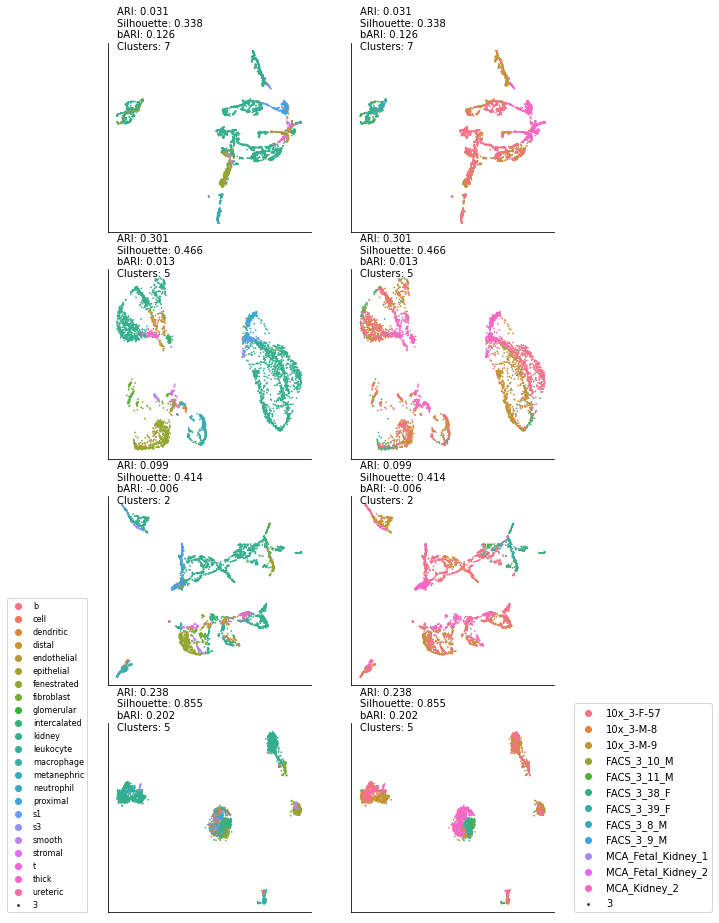

In [6]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1)) 

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot((total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_log(total_data), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_total20000(total_data), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_log(df_total20000(total_data)), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

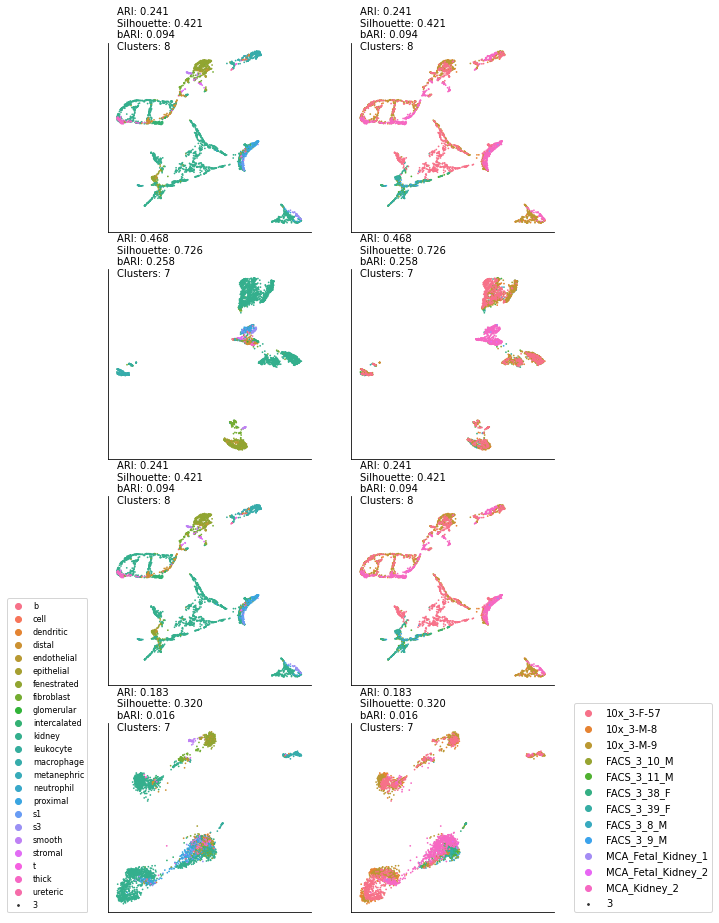

In [7]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_minmax(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

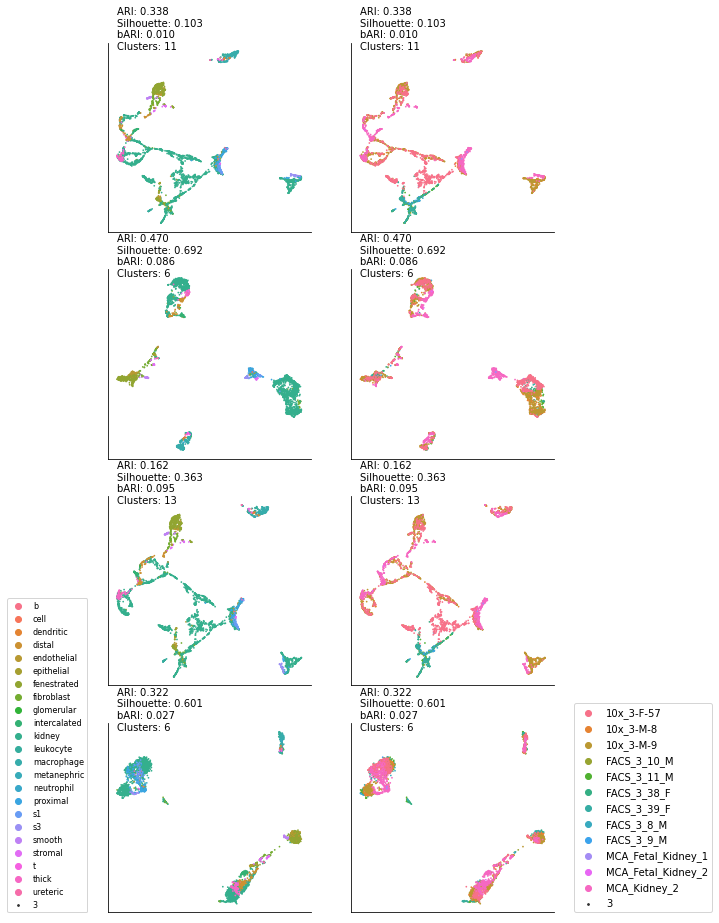

In [8]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_meansquare(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

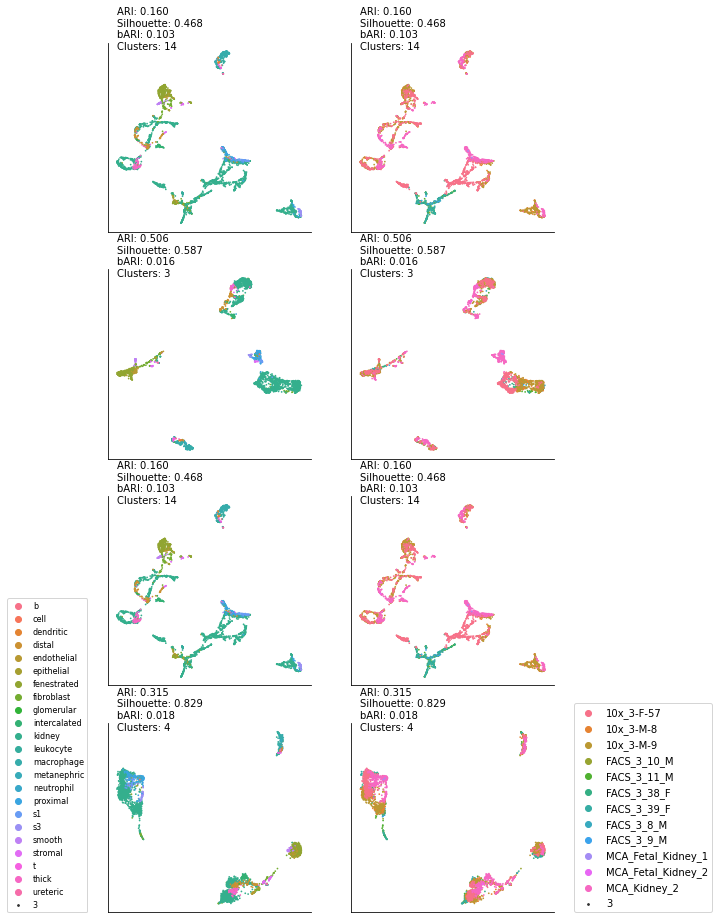

In [9]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_l2norm(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

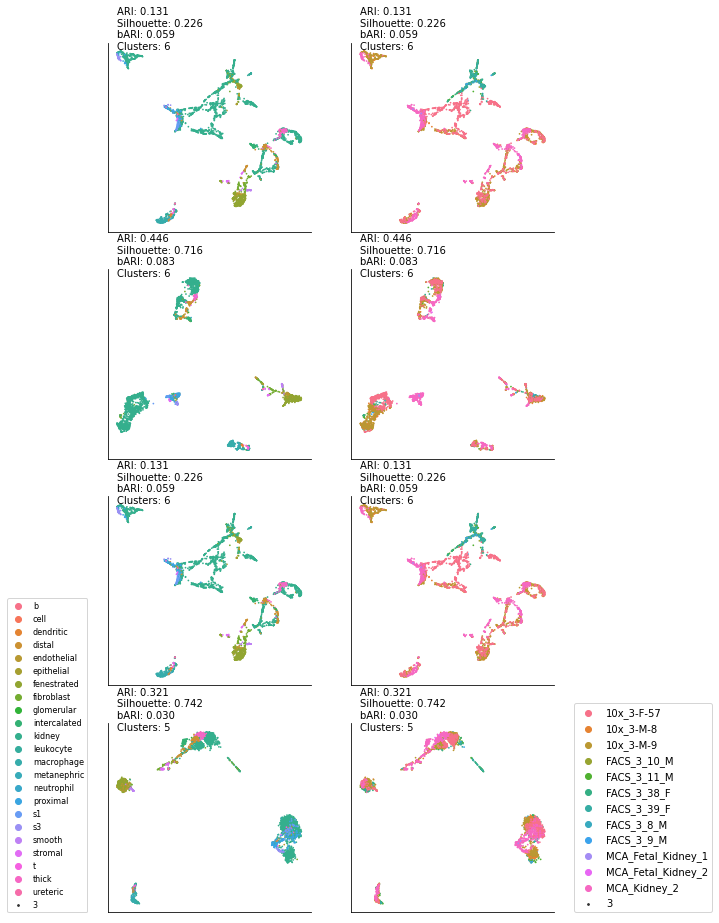

In [10]:
plt.figure(figsize=(8,16))
ax00 = plt.subplot2grid((4,2), (0,0)) 
ax01 = plt.subplot2grid((4,2), (0,1)) 

ax10 = plt.subplot2grid((4,2), (1,0)) 
ax11 = plt.subplot2grid((4,2), (1,1)) 

ax20 = plt.subplot2grid((4,2), (2,0)) 
ax21 = plt.subplot2grid((4,2), (2,1)) 

ax30 = plt.subplot2grid((4,2), (3,0)) 
ax31 = plt.subplot2grid((4,2), (3,1))

clustering_method = 'dbscan'
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(total_data), \
         ax00, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax01)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(df_log(total_data)), \
         ax10, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax11)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(df_total20000(total_data)), \
         ax20, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax21)
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
run_plot(df_zscore(df_log(df_total20000(total_data))), \
         ax30, new_labels, latent_space, clustering_method, blabels=blabels, b_ax=ax31)
ax30.legend(bbox_to_anchor=(-0.1,0), loc='lower right',borderaxespad=0,fontsize=8)
ax31.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)